# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

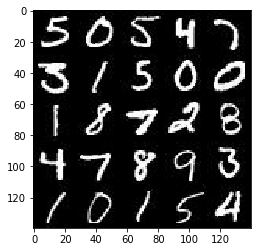

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

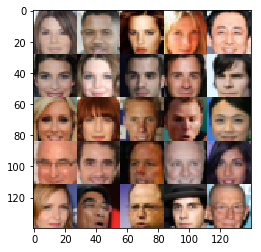

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None , image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    drop = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        #print ('Images:',images.shape)
        #Input is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              padding='same', use_bias=False, activation=None)
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.layers.dropout(x1, rate=drop, training=True)
        relu1 = tf.maximum(alpha * x1, x1)
        #relu1 = tf.nn.dropout(relu1, drop)
        #16x16x32
        #print ('L1:',relu1.shape)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              padding='same',use_bias=False, activation=None)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        bn2 = tf.layers.dropout(bn2, rate=drop, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #relu2 = tf.nn.dropout(relu2, drop)
        
        #8x8x128
        #print ('L2:',relu2.shape)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              padding='same',use_bias=False, activation=None)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        bn3 = tf.layers.dropout(bn3, rate=drop, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #relu3 = tf.nn.dropout(relu3, drop)
        #print ('L3:',relu3.shape)
        
        #Flatten 
        flat = tf.reshape(relu3, (-1, 4*4*256))
        #print ('Out:', flat.shape)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    drop = 0.5
    with tf.variable_scope('generator', reuse=(not is_train)):
        #print ('z:',z.shape)
        x1 = tf.layers.dense(z, 4*4*256)
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        bn1 = tf.layers.dropout(bn1, rate=drop, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        
        #print ('GL1:',relu1.shape)
        #256
        x2 = tf.layers.conv2d_transpose(relu1, 128, 4, strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              padding='valid')
        #x2 = tf.layers.dropout(x2, rate=drop, training=True)
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print ('GL2:',relu2.shape)
        #128
        x3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        bn3 = tf.layers.dropout(bn3, rate=drop, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print ('GL3:',relu3.shape)
        
        #Output
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same') 
        #print ('Out:',logits.shape)
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    #Label Smoothing, i.e. if you have two target labels: Real=1 and Fake=0, then for each incoming sample, if it is real, then replace the label with a random number between 0.7 and 1.2, and if it is a fake sample, replace it with 0.0 and 0.3 (for example).
    #Salimans et. al. 2016
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*np.random.uniform(0.0, 0.9)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*np.random.uniform(0.7, 0.9)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                #Normalize
                batch_images *= 2
                #Sample Noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #Optimizer 
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, learn_rate: learning_rate})
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5883... Generator Loss: 3.6058
Epoch 1/2... Discriminator Loss: 1.8002... Generator Loss: 11.0824
Epoch 1/2... Discriminator Loss: 0.5802... Generator Loss: 2.7448
Epoch 1/2... Discriminator Loss: 0.7559... Generator Loss: 2.2827
Epoch 1/2... Discriminator Loss: 0.5373... Generator Loss: 3.4111
Epoch 1/2... Discriminator Loss: 0.7216... Generator Loss: 2.3714
Epoch 1/2... Discriminator Loss: 0.7020... Generator Loss: 7.3221
Epoch 1/2... Discriminator Loss: 0.5331... Generator Loss: 3.0227
Epoch 1/2... Discriminator Loss: 0.5611... Generator Loss: 3.8771


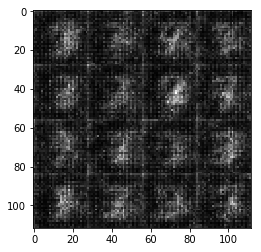

Epoch 1/2... Discriminator Loss: 0.6024... Generator Loss: 3.0529
Epoch 1/2... Discriminator Loss: 0.6300... Generator Loss: 2.4223
Epoch 1/2... Discriminator Loss: 0.5360... Generator Loss: 3.3219
Epoch 1/2... Discriminator Loss: 0.5387... Generator Loss: 3.5083
Epoch 1/2... Discriminator Loss: 0.5247... Generator Loss: 3.5931
Epoch 1/2... Discriminator Loss: 0.5445... Generator Loss: 4.1419
Epoch 1/2... Discriminator Loss: 0.5816... Generator Loss: 2.5046
Epoch 1/2... Discriminator Loss: 0.5896... Generator Loss: 2.5094
Epoch 1/2... Discriminator Loss: 0.6519... Generator Loss: 2.2359
Epoch 1/2... Discriminator Loss: 0.5943... Generator Loss: 2.5536


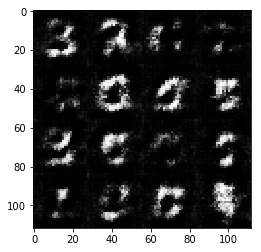

Epoch 1/2... Discriminator Loss: 0.6033... Generator Loss: 2.8286
Epoch 1/2... Discriminator Loss: 0.5369... Generator Loss: 3.1312
Epoch 1/2... Discriminator Loss: 0.5792... Generator Loss: 3.2213
Epoch 1/2... Discriminator Loss: 0.5410... Generator Loss: 3.1028
Epoch 1/2... Discriminator Loss: 0.5528... Generator Loss: 3.0586
Epoch 1/2... Discriminator Loss: 0.5813... Generator Loss: 3.4175
Epoch 1/2... Discriminator Loss: 0.5733... Generator Loss: 2.4180
Epoch 1/2... Discriminator Loss: 0.5603... Generator Loss: 3.4063
Epoch 1/2... Discriminator Loss: 0.6187... Generator Loss: 2.2005
Epoch 1/2... Discriminator Loss: 0.5690... Generator Loss: 2.7184


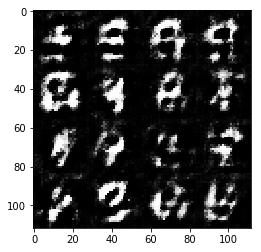

Epoch 1/2... Discriminator Loss: 0.5630... Generator Loss: 2.5841
Epoch 1/2... Discriminator Loss: 0.5433... Generator Loss: 2.7910
Epoch 1/2... Discriminator Loss: 0.5520... Generator Loss: 3.5146
Epoch 1/2... Discriminator Loss: 0.5908... Generator Loss: 2.8960
Epoch 1/2... Discriminator Loss: 0.5444... Generator Loss: 2.8973
Epoch 1/2... Discriminator Loss: 0.5994... Generator Loss: 2.3429
Epoch 1/2... Discriminator Loss: 0.6214... Generator Loss: 2.4856
Epoch 1/2... Discriminator Loss: 0.5369... Generator Loss: 2.7372
Epoch 1/2... Discriminator Loss: 0.5485... Generator Loss: 3.5487
Epoch 1/2... Discriminator Loss: 0.5721... Generator Loss: 3.5430


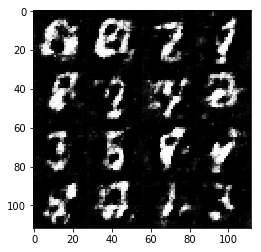

Epoch 1/2... Discriminator Loss: 0.6064... Generator Loss: 3.7335
Epoch 1/2... Discriminator Loss: 0.6023... Generator Loss: 3.8106
Epoch 1/2... Discriminator Loss: 0.5852... Generator Loss: 3.3792
Epoch 1/2... Discriminator Loss: 0.5485... Generator Loss: 3.7112
Epoch 1/2... Discriminator Loss: 0.5685... Generator Loss: 2.8559
Epoch 1/2... Discriminator Loss: 0.5601... Generator Loss: 2.9472
Epoch 1/2... Discriminator Loss: 0.7044... Generator Loss: 4.6042
Epoch 1/2... Discriminator Loss: 0.5290... Generator Loss: 3.0363
Epoch 1/2... Discriminator Loss: 0.5532... Generator Loss: 2.6948
Epoch 1/2... Discriminator Loss: 0.6202... Generator Loss: 2.0062


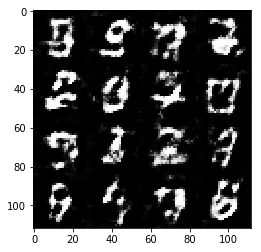

Epoch 1/2... Discriminator Loss: 0.5611... Generator Loss: 2.7451
Epoch 1/2... Discriminator Loss: 0.5498... Generator Loss: 2.7500
Epoch 1/2... Discriminator Loss: 0.5709... Generator Loss: 3.5121
Epoch 1/2... Discriminator Loss: 0.6157... Generator Loss: 2.9269
Epoch 1/2... Discriminator Loss: 0.6044... Generator Loss: 2.3861
Epoch 1/2... Discriminator Loss: 0.5362... Generator Loss: 3.1285
Epoch 1/2... Discriminator Loss: 0.5610... Generator Loss: 2.8156
Epoch 1/2... Discriminator Loss: 0.5775... Generator Loss: 2.5386
Epoch 1/2... Discriminator Loss: 0.5919... Generator Loss: 3.7556
Epoch 1/2... Discriminator Loss: 0.5916... Generator Loss: 2.6696


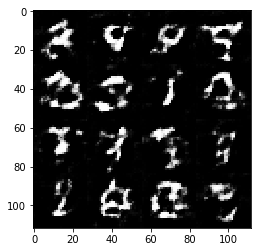

Epoch 1/2... Discriminator Loss: 0.5983... Generator Loss: 3.9172
Epoch 1/2... Discriminator Loss: 0.6034... Generator Loss: 2.4067
Epoch 1/2... Discriminator Loss: 0.5588... Generator Loss: 2.9809
Epoch 1/2... Discriminator Loss: 0.5374... Generator Loss: 2.7600
Epoch 1/2... Discriminator Loss: 0.5452... Generator Loss: 3.7241
Epoch 1/2... Discriminator Loss: 0.5609... Generator Loss: 2.5218
Epoch 1/2... Discriminator Loss: 0.5396... Generator Loss: 2.6587
Epoch 1/2... Discriminator Loss: 0.5473... Generator Loss: 2.6891
Epoch 1/2... Discriminator Loss: 0.5544... Generator Loss: 2.6638
Epoch 1/2... Discriminator Loss: 0.5577... Generator Loss: 2.7137


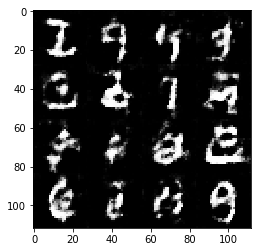

Epoch 1/2... Discriminator Loss: 0.5921... Generator Loss: 4.1596
Epoch 1/2... Discriminator Loss: 0.6058... Generator Loss: 2.2020
Epoch 1/2... Discriminator Loss: 0.5851... Generator Loss: 2.4071
Epoch 1/2... Discriminator Loss: 0.5602... Generator Loss: 2.5480
Epoch 1/2... Discriminator Loss: 0.5300... Generator Loss: 2.9070
Epoch 1/2... Discriminator Loss: 0.5764... Generator Loss: 3.4951
Epoch 1/2... Discriminator Loss: 0.6060... Generator Loss: 3.9287
Epoch 1/2... Discriminator Loss: 0.6476... Generator Loss: 4.0132
Epoch 1/2... Discriminator Loss: 0.5967... Generator Loss: 2.4765
Epoch 1/2... Discriminator Loss: 0.6101... Generator Loss: 2.2639


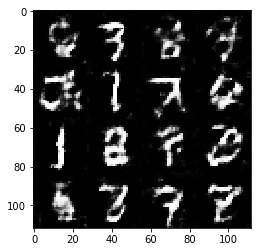

Epoch 1/2... Discriminator Loss: 0.7748... Generator Loss: 4.8756
Epoch 1/2... Discriminator Loss: 0.5537... Generator Loss: 2.5800
Epoch 1/2... Discriminator Loss: 0.5547... Generator Loss: 2.6430
Epoch 1/2... Discriminator Loss: 0.6280... Generator Loss: 4.1307
Epoch 1/2... Discriminator Loss: 0.5537... Generator Loss: 2.3873
Epoch 1/2... Discriminator Loss: 0.5576... Generator Loss: 2.5112
Epoch 1/2... Discriminator Loss: 0.5825... Generator Loss: 2.7381
Epoch 1/2... Discriminator Loss: 0.5492... Generator Loss: 2.5864
Epoch 1/2... Discriminator Loss: 0.5656... Generator Loss: 3.6727
Epoch 1/2... Discriminator Loss: 0.5645... Generator Loss: 3.4790


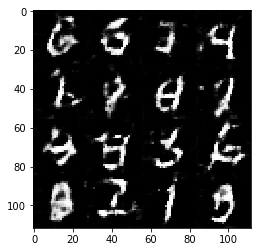

Epoch 1/2... Discriminator Loss: 0.5410... Generator Loss: 2.8420
Epoch 1/2... Discriminator Loss: 0.5220... Generator Loss: 3.1653
Epoch 1/2... Discriminator Loss: 0.5410... Generator Loss: 2.9789
Epoch 1/2... Discriminator Loss: 0.5252... Generator Loss: 3.5364
Epoch 1/2... Discriminator Loss: 0.5715... Generator Loss: 3.8839
Epoch 1/2... Discriminator Loss: 0.5900... Generator Loss: 2.3309
Epoch 1/2... Discriminator Loss: 0.5721... Generator Loss: 2.6968
Epoch 1/2... Discriminator Loss: 0.6554... Generator Loss: 4.6690
Epoch 1/2... Discriminator Loss: 0.5748... Generator Loss: 2.4007
Epoch 1/2... Discriminator Loss: 0.6037... Generator Loss: 2.6990


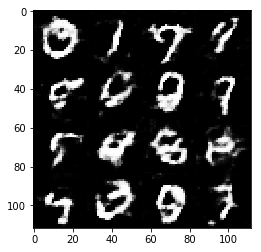

Epoch 1/2... Discriminator Loss: 0.6362... Generator Loss: 4.1835
Epoch 1/2... Discriminator Loss: 0.5344... Generator Loss: 2.8572
Epoch 1/2... Discriminator Loss: 0.5536... Generator Loss: 3.6348
Epoch 1/2... Discriminator Loss: 0.5282... Generator Loss: 3.1295
Epoch 1/2... Discriminator Loss: 0.6704... Generator Loss: 4.5395
Epoch 1/2... Discriminator Loss: 0.5732... Generator Loss: 2.3673
Epoch 1/2... Discriminator Loss: 0.5193... Generator Loss: 3.2669
Epoch 1/2... Discriminator Loss: 0.5413... Generator Loss: 3.1109
Epoch 1/2... Discriminator Loss: 0.5664... Generator Loss: 3.7343
Epoch 1/2... Discriminator Loss: 0.5709... Generator Loss: 2.8677


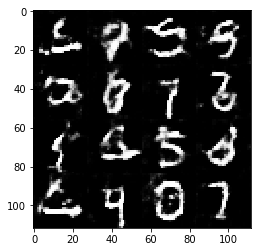

Epoch 1/2... Discriminator Loss: 0.5951... Generator Loss: 2.4419
Epoch 1/2... Discriminator Loss: 0.5411... Generator Loss: 2.7908
Epoch 1/2... Discriminator Loss: 0.5313... Generator Loss: 2.7345
Epoch 1/2... Discriminator Loss: 0.5794... Generator Loss: 3.5116
Epoch 1/2... Discriminator Loss: 0.5563... Generator Loss: 3.3231
Epoch 1/2... Discriminator Loss: 0.5700... Generator Loss: 2.3851
Epoch 1/2... Discriminator Loss: 0.5529... Generator Loss: 2.7993
Epoch 1/2... Discriminator Loss: 0.5548... Generator Loss: 2.7801
Epoch 1/2... Discriminator Loss: 0.5355... Generator Loss: 3.2632
Epoch 1/2... Discriminator Loss: 0.5901... Generator Loss: 3.7447


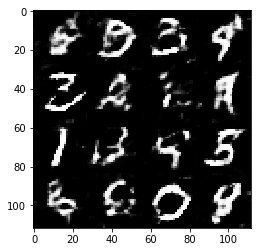

Epoch 1/2... Discriminator Loss: 0.5358... Generator Loss: 3.1186
Epoch 1/2... Discriminator Loss: 0.5588... Generator Loss: 3.6156
Epoch 1/2... Discriminator Loss: 0.5357... Generator Loss: 3.0970
Epoch 1/2... Discriminator Loss: 0.5425... Generator Loss: 2.8429
Epoch 1/2... Discriminator Loss: 0.5342... Generator Loss: 2.9662
Epoch 1/2... Discriminator Loss: 0.5256... Generator Loss: 2.7549
Epoch 1/2... Discriminator Loss: 0.5416... Generator Loss: 2.8255
Epoch 1/2... Discriminator Loss: 0.5552... Generator Loss: 2.6957
Epoch 1/2... Discriminator Loss: 0.5465... Generator Loss: 3.3878
Epoch 1/2... Discriminator Loss: 0.6330... Generator Loss: 4.1614


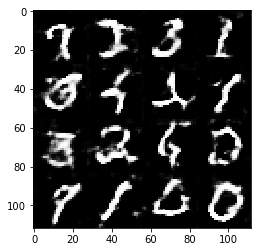

Epoch 1/2... Discriminator Loss: 0.5813... Generator Loss: 3.4225
Epoch 1/2... Discriminator Loss: 0.5716... Generator Loss: 2.5037
Epoch 1/2... Discriminator Loss: 0.5492... Generator Loss: 2.7425
Epoch 1/2... Discriminator Loss: 0.5829... Generator Loss: 2.4320
Epoch 1/2... Discriminator Loss: 0.5473... Generator Loss: 3.1719
Epoch 1/2... Discriminator Loss: 0.5588... Generator Loss: 3.7822
Epoch 1/2... Discriminator Loss: 0.6905... Generator Loss: 4.4432
Epoch 1/2... Discriminator Loss: 0.5688... Generator Loss: 2.5132
Epoch 1/2... Discriminator Loss: 0.5486... Generator Loss: 3.0489
Epoch 1/2... Discriminator Loss: 0.5390... Generator Loss: 2.9035


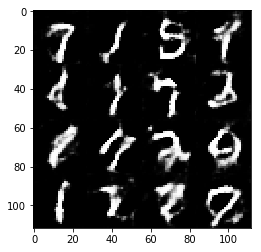

Epoch 1/2... Discriminator Loss: 0.5388... Generator Loss: 3.9574
Epoch 1/2... Discriminator Loss: 0.5450... Generator Loss: 3.1131
Epoch 1/2... Discriminator Loss: 0.5376... Generator Loss: 2.6901
Epoch 1/2... Discriminator Loss: 0.5651... Generator Loss: 2.7804
Epoch 1/2... Discriminator Loss: 0.5258... Generator Loss: 3.3475
Epoch 1/2... Discriminator Loss: 0.7406... Generator Loss: 5.1355
Epoch 1/2... Discriminator Loss: 0.5374... Generator Loss: 2.7023
Epoch 1/2... Discriminator Loss: 0.5289... Generator Loss: 3.2403
Epoch 1/2... Discriminator Loss: 0.5405... Generator Loss: 3.5796
Epoch 1/2... Discriminator Loss: 0.5250... Generator Loss: 3.0199


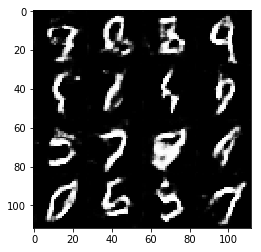

Epoch 1/2... Discriminator Loss: 0.5044... Generator Loss: 3.1057
Epoch 1/2... Discriminator Loss: 0.5545... Generator Loss: 2.4035
Epoch 1/2... Discriminator Loss: 0.5662... Generator Loss: 3.7018
Epoch 1/2... Discriminator Loss: 0.5366... Generator Loss: 2.9489
Epoch 1/2... Discriminator Loss: 0.5472... Generator Loss: 2.5625
Epoch 1/2... Discriminator Loss: 0.5556... Generator Loss: 2.7325
Epoch 1/2... Discriminator Loss: 0.5680... Generator Loss: 2.7057
Epoch 1/2... Discriminator Loss: 0.5681... Generator Loss: 3.8537
Epoch 1/2... Discriminator Loss: 0.5236... Generator Loss: 2.9797
Epoch 1/2... Discriminator Loss: 0.6827... Generator Loss: 4.3967


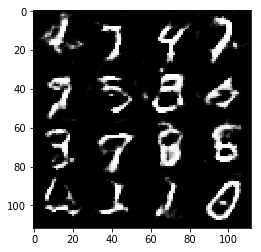

Epoch 1/2... Discriminator Loss: 0.5475... Generator Loss: 2.9568
Epoch 1/2... Discriminator Loss: 0.5624... Generator Loss: 2.6279
Epoch 1/2... Discriminator Loss: 0.5613... Generator Loss: 3.6448
Epoch 1/2... Discriminator Loss: 0.5776... Generator Loss: 4.0650
Epoch 1/2... Discriminator Loss: 0.5446... Generator Loss: 2.8782
Epoch 1/2... Discriminator Loss: 0.6597... Generator Loss: 4.4704
Epoch 1/2... Discriminator Loss: 0.5717... Generator Loss: 3.6197
Epoch 1/2... Discriminator Loss: 0.5341... Generator Loss: 3.5734
Epoch 1/2... Discriminator Loss: 0.5327... Generator Loss: 3.0881
Epoch 1/2... Discriminator Loss: 0.5337... Generator Loss: 2.8304


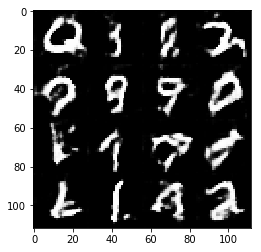

Epoch 1/2... Discriminator Loss: 0.5801... Generator Loss: 3.2088
Epoch 1/2... Discriminator Loss: 0.5530... Generator Loss: 2.7767
Epoch 1/2... Discriminator Loss: 0.5278... Generator Loss: 2.9621
Epoch 1/2... Discriminator Loss: 0.5518... Generator Loss: 2.7230
Epoch 1/2... Discriminator Loss: 0.5329... Generator Loss: 3.1196
Epoch 1/2... Discriminator Loss: 0.5677... Generator Loss: 3.3258
Epoch 1/2... Discriminator Loss: 0.5131... Generator Loss: 3.3043
Epoch 1/2... Discriminator Loss: 0.5313... Generator Loss: 3.3353
Epoch 1/2... Discriminator Loss: 0.5722... Generator Loss: 2.7582
Epoch 1/2... Discriminator Loss: 0.5539... Generator Loss: 2.8697


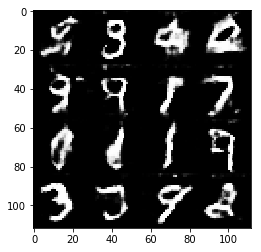

Epoch 1/2... Discriminator Loss: 0.5246... Generator Loss: 3.9802
Epoch 1/2... Discriminator Loss: 0.6424... Generator Loss: 2.3260
Epoch 1/2... Discriminator Loss: 0.5225... Generator Loss: 3.5016
Epoch 1/2... Discriminator Loss: 0.5350... Generator Loss: 3.4893
Epoch 1/2... Discriminator Loss: 0.5246... Generator Loss: 2.8738
Epoch 1/2... Discriminator Loss: 0.5322... Generator Loss: 2.9458
Epoch 1/2... Discriminator Loss: 0.5399... Generator Loss: 3.6253
Epoch 1/2... Discriminator Loss: 0.5488... Generator Loss: 4.0068
Epoch 1/2... Discriminator Loss: 0.5184... Generator Loss: 3.8132
Epoch 1/2... Discriminator Loss: 0.5444... Generator Loss: 3.9397


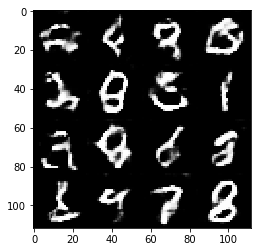

Epoch 1/2... Discriminator Loss: 0.5238... Generator Loss: 3.1552
Epoch 1/2... Discriminator Loss: 0.6522... Generator Loss: 2.2127
Epoch 1/2... Discriminator Loss: 0.5443... Generator Loss: 3.6376
Epoch 1/2... Discriminator Loss: 0.5406... Generator Loss: 2.9205
Epoch 1/2... Discriminator Loss: 0.5417... Generator Loss: 3.0517
Epoch 1/2... Discriminator Loss: 0.6116... Generator Loss: 4.3085
Epoch 1/2... Discriminator Loss: 0.5347... Generator Loss: 2.9811
Epoch 1/2... Discriminator Loss: 0.5797... Generator Loss: 2.5737
Epoch 1/2... Discriminator Loss: 0.5324... Generator Loss: 2.8683
Epoch 1/2... Discriminator Loss: 0.6407... Generator Loss: 4.3110


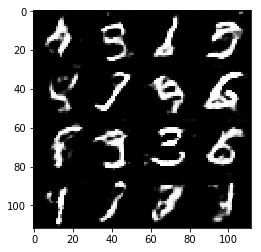

Epoch 1/2... Discriminator Loss: 0.6348... Generator Loss: 2.4201
Epoch 1/2... Discriminator Loss: 0.5398... Generator Loss: 3.0859
Epoch 1/2... Discriminator Loss: 0.5196... Generator Loss: 3.0892
Epoch 1/2... Discriminator Loss: 0.5770... Generator Loss: 2.8796
Epoch 1/2... Discriminator Loss: 0.5178... Generator Loss: 3.6905
Epoch 1/2... Discriminator Loss: 0.5213... Generator Loss: 2.8565
Epoch 1/2... Discriminator Loss: 0.5546... Generator Loss: 3.8864
Epoch 1/2... Discriminator Loss: 0.5370... Generator Loss: 2.8129
Epoch 1/2... Discriminator Loss: 0.5753... Generator Loss: 3.6151
Epoch 1/2... Discriminator Loss: 0.5597... Generator Loss: 2.7714


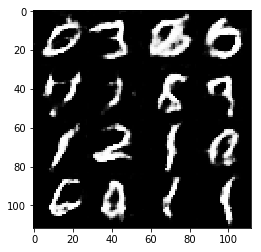

Epoch 1/2... Discriminator Loss: 0.6467... Generator Loss: 4.1399
Epoch 1/2... Discriminator Loss: 0.5827... Generator Loss: 4.1496
Epoch 1/2... Discriminator Loss: 0.5678... Generator Loss: 3.1479
Epoch 1/2... Discriminator Loss: 0.5213... Generator Loss: 3.6486
Epoch 1/2... Discriminator Loss: 0.5242... Generator Loss: 3.4571
Epoch 1/2... Discriminator Loss: 0.5686... Generator Loss: 2.7506
Epoch 1/2... Discriminator Loss: 0.6569... Generator Loss: 4.2998
Epoch 1/2... Discriminator Loss: 0.5671... Generator Loss: 3.0352
Epoch 1/2... Discriminator Loss: 0.5996... Generator Loss: 2.4415
Epoch 1/2... Discriminator Loss: 0.5136... Generator Loss: 3.1291


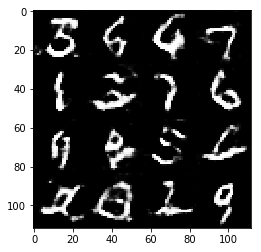

Epoch 1/2... Discriminator Loss: 0.5260... Generator Loss: 3.2944
Epoch 1/2... Discriminator Loss: 0.5411... Generator Loss: 2.8658
Epoch 1/2... Discriminator Loss: 0.6341... Generator Loss: 4.3639
Epoch 1/2... Discriminator Loss: 0.5539... Generator Loss: 3.6792
Epoch 1/2... Discriminator Loss: 0.5292... Generator Loss: 3.2551
Epoch 1/2... Discriminator Loss: 0.5242... Generator Loss: 3.0296
Epoch 1/2... Discriminator Loss: 0.5497... Generator Loss: 3.2991
Epoch 1/2... Discriminator Loss: 0.7143... Generator Loss: 5.0328
Epoch 1/2... Discriminator Loss: 0.5575... Generator Loss: 2.9303
Epoch 1/2... Discriminator Loss: 0.5670... Generator Loss: 2.9845


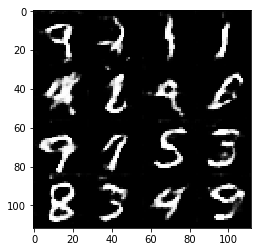

Epoch 1/2... Discriminator Loss: 0.5243... Generator Loss: 4.2615
Epoch 1/2... Discriminator Loss: 0.5163... Generator Loss: 3.0466
Epoch 1/2... Discriminator Loss: 0.5494... Generator Loss: 3.6035
Epoch 1/2... Discriminator Loss: 0.5083... Generator Loss: 3.5211
Epoch 1/2... Discriminator Loss: 0.5404... Generator Loss: 4.0811
Epoch 1/2... Discriminator Loss: 0.7169... Generator Loss: 4.8859
Epoch 1/2... Discriminator Loss: 0.5048... Generator Loss: 3.6380
Epoch 1/2... Discriminator Loss: 0.5161... Generator Loss: 3.6507
Epoch 1/2... Discriminator Loss: 0.5359... Generator Loss: 3.7835
Epoch 1/2... Discriminator Loss: 0.5273... Generator Loss: 3.0406


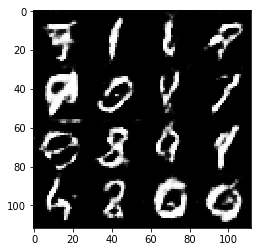

Epoch 1/2... Discriminator Loss: 0.5322... Generator Loss: 3.0216
Epoch 1/2... Discriminator Loss: 0.5216... Generator Loss: 3.2153
Epoch 1/2... Discriminator Loss: 0.5130... Generator Loss: 3.0741
Epoch 1/2... Discriminator Loss: 0.6103... Generator Loss: 3.7776
Epoch 1/2... Discriminator Loss: 0.5374... Generator Loss: 3.1700
Epoch 1/2... Discriminator Loss: 0.6006... Generator Loss: 4.3464
Epoch 1/2... Discriminator Loss: 0.5736... Generator Loss: 2.5790
Epoch 1/2... Discriminator Loss: 0.5254... Generator Loss: 3.3542
Epoch 1/2... Discriminator Loss: 0.5313... Generator Loss: 3.1657
Epoch 1/2... Discriminator Loss: 0.5095... Generator Loss: 3.8862


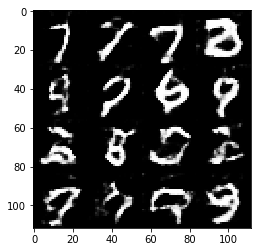

Epoch 1/2... Discriminator Loss: 0.6358... Generator Loss: 4.4753
Epoch 1/2... Discriminator Loss: 0.5310... Generator Loss: 3.1542
Epoch 1/2... Discriminator Loss: 0.5429... Generator Loss: 3.4122
Epoch 1/2... Discriminator Loss: 0.5141... Generator Loss: 3.0210
Epoch 1/2... Discriminator Loss: 0.5226... Generator Loss: 3.6613
Epoch 1/2... Discriminator Loss: 0.5159... Generator Loss: 3.1504
Epoch 1/2... Discriminator Loss: 0.5321... Generator Loss: 3.2816
Epoch 1/2... Discriminator Loss: 0.5304... Generator Loss: 3.8974
Epoch 1/2... Discriminator Loss: 0.4988... Generator Loss: 3.4884
Epoch 1/2... Discriminator Loss: 0.6185... Generator Loss: 4.0616


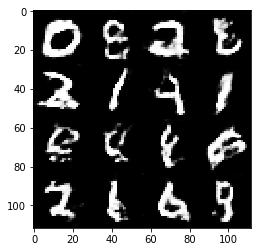

Epoch 1/2... Discriminator Loss: 0.5189... Generator Loss: 3.9679
Epoch 1/2... Discriminator Loss: 0.6332... Generator Loss: 2.6624
Epoch 1/2... Discriminator Loss: 0.5198... Generator Loss: 3.5718
Epoch 1/2... Discriminator Loss: 0.6850... Generator Loss: 4.2928
Epoch 1/2... Discriminator Loss: 0.5696... Generator Loss: 3.2744
Epoch 1/2... Discriminator Loss: 0.5214... Generator Loss: 3.2706
Epoch 1/2... Discriminator Loss: 0.5134... Generator Loss: 4.1580
Epoch 1/2... Discriminator Loss: 0.5307... Generator Loss: 3.9974
Epoch 1/2... Discriminator Loss: 0.5226... Generator Loss: 3.2290
Epoch 1/2... Discriminator Loss: 0.5204... Generator Loss: 3.0666


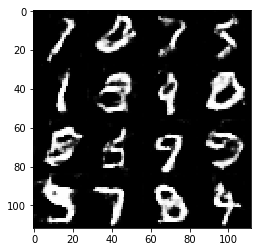

Epoch 1/2... Discriminator Loss: 0.6032... Generator Loss: 3.0001
Epoch 1/2... Discriminator Loss: 0.5128... Generator Loss: 3.2412
Epoch 1/2... Discriminator Loss: 0.5339... Generator Loss: 3.6355
Epoch 1/2... Discriminator Loss: 0.5078... Generator Loss: 3.7607
Epoch 1/2... Discriminator Loss: 0.5254... Generator Loss: 2.8405
Epoch 1/2... Discriminator Loss: 0.5405... Generator Loss: 3.0533
Epoch 1/2... Discriminator Loss: 0.5389... Generator Loss: 3.2092
Epoch 1/2... Discriminator Loss: 0.5256... Generator Loss: 3.0969
Epoch 1/2... Discriminator Loss: 0.4954... Generator Loss: 3.8082
Epoch 1/2... Discriminator Loss: 0.5079... Generator Loss: 3.8906


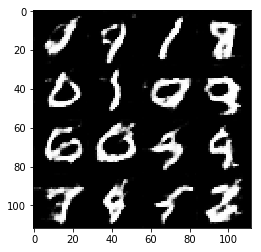

Epoch 1/2... Discriminator Loss: 0.5053... Generator Loss: 3.3803
Epoch 1/2... Discriminator Loss: 0.6008... Generator Loss: 2.9258
Epoch 1/2... Discriminator Loss: 0.5341... Generator Loss: 3.9060
Epoch 1/2... Discriminator Loss: 0.5204... Generator Loss: 3.8214
Epoch 1/2... Discriminator Loss: 0.5152... Generator Loss: 3.4524
Epoch 1/2... Discriminator Loss: 0.5145... Generator Loss: 3.0211
Epoch 1/2... Discriminator Loss: 0.5713... Generator Loss: 2.9585
Epoch 1/2... Discriminator Loss: 0.5169... Generator Loss: 3.2157
Epoch 1/2... Discriminator Loss: 0.5287... Generator Loss: 3.2595
Epoch 1/2... Discriminator Loss: 0.5034... Generator Loss: 3.2180


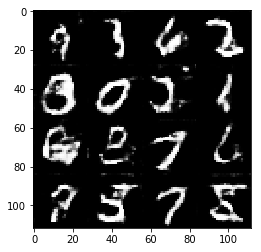

Epoch 1/2... Discriminator Loss: 0.5107... Generator Loss: 3.4245
Epoch 1/2... Discriminator Loss: 0.5069... Generator Loss: 3.3526
Epoch 1/2... Discriminator Loss: 0.5378... Generator Loss: 2.9705
Epoch 1/2... Discriminator Loss: 0.5523... Generator Loss: 2.9860
Epoch 1/2... Discriminator Loss: 0.5563... Generator Loss: 3.1446
Epoch 1/2... Discriminator Loss: 0.5380... Generator Loss: 2.9021
Epoch 1/2... Discriminator Loss: 0.5687... Generator Loss: 2.7954
Epoch 1/2... Discriminator Loss: 0.5780... Generator Loss: 2.7994
Epoch 1/2... Discriminator Loss: 0.5066... Generator Loss: 3.1278
Epoch 1/2... Discriminator Loss: 0.5070... Generator Loss: 3.3001


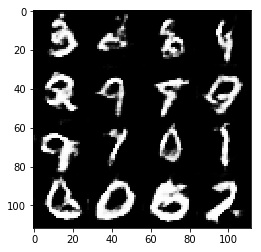

Epoch 1/2... Discriminator Loss: 0.5227... Generator Loss: 3.2222
Epoch 1/2... Discriminator Loss: 0.5372... Generator Loss: 2.9814
Epoch 1/2... Discriminator Loss: 0.5173... Generator Loss: 3.3495
Epoch 1/2... Discriminator Loss: 0.5371... Generator Loss: 2.8850
Epoch 1/2... Discriminator Loss: 0.5269... Generator Loss: 3.2499
Epoch 1/2... Discriminator Loss: 0.5151... Generator Loss: 3.7520
Epoch 1/2... Discriminator Loss: 0.5216... Generator Loss: 4.2766
Epoch 1/2... Discriminator Loss: 0.5273... Generator Loss: 3.0793
Epoch 1/2... Discriminator Loss: 0.5245... Generator Loss: 4.2995
Epoch 1/2... Discriminator Loss: 0.6255... Generator Loss: 4.3366


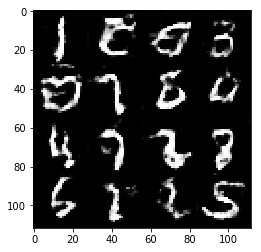

Epoch 1/2... Discriminator Loss: 0.5199... Generator Loss: 3.6187
Epoch 1/2... Discriminator Loss: 0.5212... Generator Loss: 3.9125
Epoch 1/2... Discriminator Loss: 0.5384... Generator Loss: 2.8318
Epoch 1/2... Discriminator Loss: 0.5343... Generator Loss: 3.7423
Epoch 1/2... Discriminator Loss: 0.5684... Generator Loss: 3.0609
Epoch 1/2... Discriminator Loss: 0.5606... Generator Loss: 3.3263
Epoch 1/2... Discriminator Loss: 0.5285... Generator Loss: 3.3631
Epoch 1/2... Discriminator Loss: 0.5039... Generator Loss: 3.2745
Epoch 1/2... Discriminator Loss: 0.6571... Generator Loss: 4.6460
Epoch 1/2... Discriminator Loss: 0.5203... Generator Loss: 3.0510


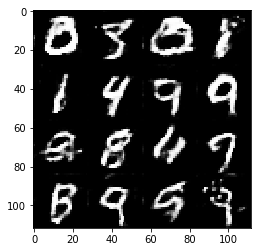

Epoch 1/2... Discriminator Loss: 0.5238... Generator Loss: 3.1842
Epoch 1/2... Discriminator Loss: 0.5835... Generator Loss: 2.7990
Epoch 1/2... Discriminator Loss: 0.5246... Generator Loss: 3.1731
Epoch 1/2... Discriminator Loss: 0.5008... Generator Loss: 3.6087
Epoch 1/2... Discriminator Loss: 0.5131... Generator Loss: 3.7407
Epoch 1/2... Discriminator Loss: 0.5275... Generator Loss: 3.0460
Epoch 1/2... Discriminator Loss: 0.5205... Generator Loss: 3.0612
Epoch 1/2... Discriminator Loss: 0.4897... Generator Loss: 3.6256
Epoch 1/2... Discriminator Loss: 0.5028... Generator Loss: 3.6802
Epoch 1/2... Discriminator Loss: 0.5751... Generator Loss: 3.0046


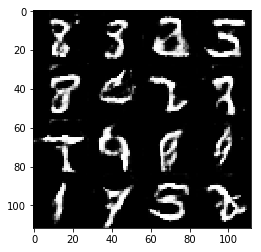

Epoch 1/2... Discriminator Loss: 0.5216... Generator Loss: 2.8825
Epoch 1/2... Discriminator Loss: 0.5408... Generator Loss: 3.5085
Epoch 1/2... Discriminator Loss: 0.5060... Generator Loss: 3.2751
Epoch 1/2... Discriminator Loss: 0.5188... Generator Loss: 3.5074
Epoch 1/2... Discriminator Loss: 0.5611... Generator Loss: 4.4333
Epoch 1/2... Discriminator Loss: 0.5557... Generator Loss: 2.9557
Epoch 1/2... Discriminator Loss: 0.5083... Generator Loss: 3.3183
Epoch 1/2... Discriminator Loss: 0.5511... Generator Loss: 4.1488
Epoch 1/2... Discriminator Loss: 0.5270... Generator Loss: 3.4272
Epoch 1/2... Discriminator Loss: 0.5710... Generator Loss: 2.6181


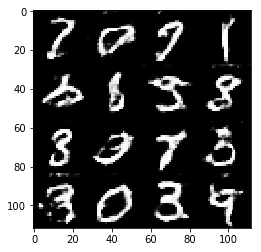

Epoch 1/2... Discriminator Loss: 0.5876... Generator Loss: 4.5881
Epoch 1/2... Discriminator Loss: 0.5768... Generator Loss: 4.1180
Epoch 1/2... Discriminator Loss: 0.5030... Generator Loss: 3.9114
Epoch 1/2... Discriminator Loss: 0.5378... Generator Loss: 4.3185
Epoch 1/2... Discriminator Loss: 0.5114... Generator Loss: 3.2745
Epoch 1/2... Discriminator Loss: 0.4975... Generator Loss: 3.5869
Epoch 1/2... Discriminator Loss: 0.5268... Generator Loss: 2.9172
Epoch 1/2... Discriminator Loss: 0.5391... Generator Loss: 2.9816
Epoch 1/2... Discriminator Loss: 0.5736... Generator Loss: 4.4717
Epoch 1/2... Discriminator Loss: 0.5244... Generator Loss: 3.4121


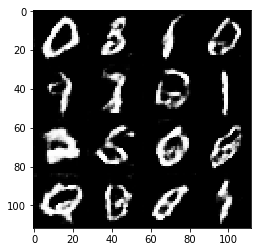

Epoch 1/2... Discriminator Loss: 0.5221... Generator Loss: 3.6421
Epoch 1/2... Discriminator Loss: 0.5070... Generator Loss: 3.2469
Epoch 1/2... Discriminator Loss: 0.5370... Generator Loss: 3.0528
Epoch 1/2... Discriminator Loss: 0.5319... Generator Loss: 3.0507
Epoch 1/2... Discriminator Loss: 0.5149... Generator Loss: 3.6444
Epoch 1/2... Discriminator Loss: 0.5400... Generator Loss: 2.9008
Epoch 1/2... Discriminator Loss: 0.5181... Generator Loss: 3.4891
Epoch 1/2... Discriminator Loss: 0.5125... Generator Loss: 3.4007
Epoch 1/2... Discriminator Loss: 0.5077... Generator Loss: 3.5680
Epoch 1/2... Discriminator Loss: 0.5189... Generator Loss: 2.9379


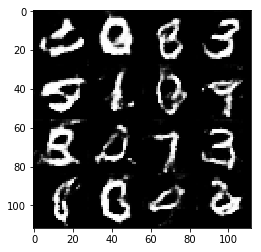

Epoch 1/2... Discriminator Loss: 0.5202... Generator Loss: 4.1284
Epoch 1/2... Discriminator Loss: 0.4983... Generator Loss: 3.6452
Epoch 1/2... Discriminator Loss: 0.5722... Generator Loss: 3.0985
Epoch 1/2... Discriminator Loss: 0.5032... Generator Loss: 3.3283
Epoch 1/2... Discriminator Loss: 0.5714... Generator Loss: 2.9315
Epoch 1/2... Discriminator Loss: 0.5537... Generator Loss: 4.2180
Epoch 1/2... Discriminator Loss: 0.5114... Generator Loss: 2.9855
Epoch 1/2... Discriminator Loss: 0.5226... Generator Loss: 4.0196
Epoch 1/2... Discriminator Loss: 0.5161... Generator Loss: 3.7521
Epoch 1/2... Discriminator Loss: 0.5176... Generator Loss: 3.8703


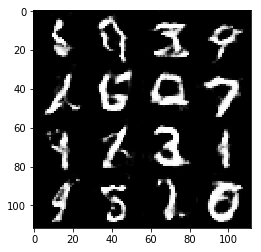

Epoch 1/2... Discriminator Loss: 0.5327... Generator Loss: 3.2101
Epoch 1/2... Discriminator Loss: 0.5213... Generator Loss: 3.7644
Epoch 1/2... Discriminator Loss: 0.5124... Generator Loss: 3.1616
Epoch 1/2... Discriminator Loss: 0.5179... Generator Loss: 3.9355
Epoch 1/2... Discriminator Loss: 0.5012... Generator Loss: 3.3360
Epoch 1/2... Discriminator Loss: 0.5785... Generator Loss: 4.6912
Epoch 2/2... Discriminator Loss: 0.5051... Generator Loss: 2.9576
Epoch 2/2... Discriminator Loss: 0.5576... Generator Loss: 4.3284
Epoch 2/2... Discriminator Loss: 0.5332... Generator Loss: 3.2662
Epoch 2/2... Discriminator Loss: 0.6178... Generator Loss: 2.4128


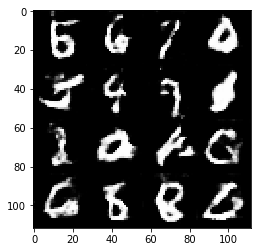

Epoch 2/2... Discriminator Loss: 0.5094... Generator Loss: 3.2345
Epoch 2/2... Discriminator Loss: 0.5098... Generator Loss: 3.3435
Epoch 2/2... Discriminator Loss: 0.5018... Generator Loss: 3.3858
Epoch 2/2... Discriminator Loss: 0.5150... Generator Loss: 3.5743
Epoch 2/2... Discriminator Loss: 0.5774... Generator Loss: 2.8037
Epoch 2/2... Discriminator Loss: 0.5125... Generator Loss: 3.4116
Epoch 2/2... Discriminator Loss: 0.5004... Generator Loss: 3.2188
Epoch 2/2... Discriminator Loss: 0.5231... Generator Loss: 3.0324
Epoch 2/2... Discriminator Loss: 0.5056... Generator Loss: 3.1340
Epoch 2/2... Discriminator Loss: 0.5386... Generator Loss: 3.0079


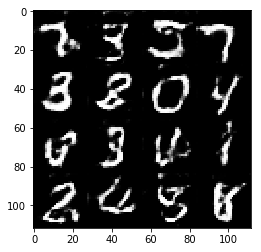

Epoch 2/2... Discriminator Loss: 0.5095... Generator Loss: 3.2427
Epoch 2/2... Discriminator Loss: 0.5124... Generator Loss: 3.3124
Epoch 2/2... Discriminator Loss: 0.5456... Generator Loss: 4.0233
Epoch 2/2... Discriminator Loss: 0.5306... Generator Loss: 4.0749
Epoch 2/2... Discriminator Loss: 0.5093... Generator Loss: 3.5974
Epoch 2/2... Discriminator Loss: 0.5525... Generator Loss: 3.8462
Epoch 2/2... Discriminator Loss: 0.4901... Generator Loss: 4.1509
Epoch 2/2... Discriminator Loss: 0.5663... Generator Loss: 3.3239
Epoch 2/2... Discriminator Loss: 0.5361... Generator Loss: 3.2425
Epoch 2/2... Discriminator Loss: 0.5485... Generator Loss: 3.1767


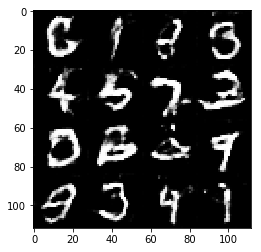

Epoch 2/2... Discriminator Loss: 0.5565... Generator Loss: 3.3884
Epoch 2/2... Discriminator Loss: 0.5220... Generator Loss: 2.9861
Epoch 2/2... Discriminator Loss: 0.5031... Generator Loss: 3.8030
Epoch 2/2... Discriminator Loss: 0.5131... Generator Loss: 3.5593
Epoch 2/2... Discriminator Loss: 0.5051... Generator Loss: 3.4866
Epoch 2/2... Discriminator Loss: 0.5807... Generator Loss: 2.9894
Epoch 2/2... Discriminator Loss: 0.5108... Generator Loss: 3.3623
Epoch 2/2... Discriminator Loss: 0.5719... Generator Loss: 3.0695
Epoch 2/2... Discriminator Loss: 0.5594... Generator Loss: 3.0430
Epoch 2/2... Discriminator Loss: 0.5068... Generator Loss: 3.6917


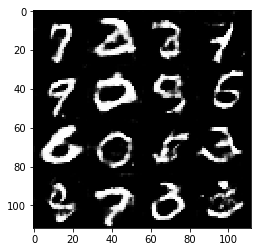

Epoch 2/2... Discriminator Loss: 0.5149... Generator Loss: 3.0458
Epoch 2/2... Discriminator Loss: 0.5078... Generator Loss: 3.3322
Epoch 2/2... Discriminator Loss: 0.5102... Generator Loss: 3.7027
Epoch 2/2... Discriminator Loss: 0.5186... Generator Loss: 4.2918
Epoch 2/2... Discriminator Loss: 0.6138... Generator Loss: 2.7404
Epoch 2/2... Discriminator Loss: 0.5198... Generator Loss: 3.9818
Epoch 2/2... Discriminator Loss: 0.5295... Generator Loss: 4.3033
Epoch 2/2... Discriminator Loss: 0.7111... Generator Loss: 5.1063
Epoch 2/2... Discriminator Loss: 0.5536... Generator Loss: 3.9662
Epoch 2/2... Discriminator Loss: 0.5417... Generator Loss: 4.1738


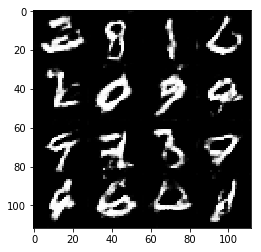

Epoch 2/2... Discriminator Loss: 0.4950... Generator Loss: 3.8850
Epoch 2/2... Discriminator Loss: 0.4846... Generator Loss: 4.2619
Epoch 2/2... Discriminator Loss: 0.5076... Generator Loss: 3.3121
Epoch 2/2... Discriminator Loss: 0.5338... Generator Loss: 3.0476
Epoch 2/2... Discriminator Loss: 0.4968... Generator Loss: 3.3566
Epoch 2/2... Discriminator Loss: 0.5130... Generator Loss: 3.5003
Epoch 2/2... Discriminator Loss: 0.5769... Generator Loss: 2.7244
Epoch 2/2... Discriminator Loss: 0.5070... Generator Loss: 3.7082
Epoch 2/2... Discriminator Loss: 0.5395... Generator Loss: 3.7779
Epoch 2/2... Discriminator Loss: 0.5621... Generator Loss: 3.8069


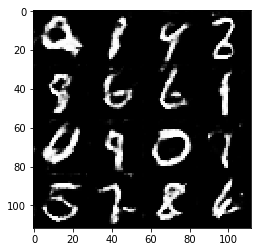

Epoch 2/2... Discriminator Loss: 0.5095... Generator Loss: 3.6850
Epoch 2/2... Discriminator Loss: 0.5151... Generator Loss: 2.8632
Epoch 2/2... Discriminator Loss: 0.5764... Generator Loss: 4.1313
Epoch 2/2... Discriminator Loss: 0.5225... Generator Loss: 4.1207
Epoch 2/2... Discriminator Loss: 0.5243... Generator Loss: 4.0094
Epoch 2/2... Discriminator Loss: 0.5012... Generator Loss: 4.2510
Epoch 2/2... Discriminator Loss: 0.5111... Generator Loss: 3.4037
Epoch 2/2... Discriminator Loss: 0.5116... Generator Loss: 3.7531
Epoch 2/2... Discriminator Loss: 0.5270... Generator Loss: 4.0199
Epoch 2/2... Discriminator Loss: 0.5311... Generator Loss: 3.1477


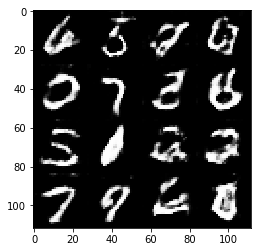

Epoch 2/2... Discriminator Loss: 0.5057... Generator Loss: 3.9199
Epoch 2/2... Discriminator Loss: 0.5115... Generator Loss: 3.2563
Epoch 2/2... Discriminator Loss: 0.5437... Generator Loss: 4.3980
Epoch 2/2... Discriminator Loss: 0.5052... Generator Loss: 3.1796
Epoch 2/2... Discriminator Loss: 0.5112... Generator Loss: 3.3441
Epoch 2/2... Discriminator Loss: 0.5211... Generator Loss: 3.1668
Epoch 2/2... Discriminator Loss: 0.5418... Generator Loss: 3.0780
Epoch 2/2... Discriminator Loss: 0.5245... Generator Loss: 3.1985
Epoch 2/2... Discriminator Loss: 0.4987... Generator Loss: 3.7268
Epoch 2/2... Discriminator Loss: 0.5683... Generator Loss: 3.1021


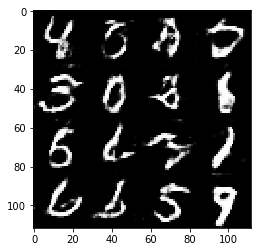

Epoch 2/2... Discriminator Loss: 0.5016... Generator Loss: 3.6641
Epoch 2/2... Discriminator Loss: 0.5003... Generator Loss: 4.4140
Epoch 2/2... Discriminator Loss: 0.5042... Generator Loss: 3.7621
Epoch 2/2... Discriminator Loss: 0.5299... Generator Loss: 3.6450
Epoch 2/2... Discriminator Loss: 0.5154... Generator Loss: 3.8177
Epoch 2/2... Discriminator Loss: 0.5761... Generator Loss: 4.6769
Epoch 2/2... Discriminator Loss: 0.5145... Generator Loss: 3.3650
Epoch 2/2... Discriminator Loss: 0.5055... Generator Loss: 3.3180
Epoch 2/2... Discriminator Loss: 0.5870... Generator Loss: 4.6305
Epoch 2/2... Discriminator Loss: 0.5034... Generator Loss: 3.6598


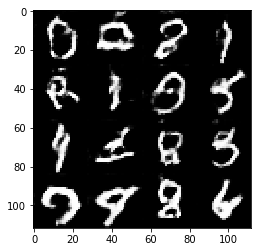

Epoch 2/2... Discriminator Loss: 0.5907... Generator Loss: 4.4515
Epoch 2/2... Discriminator Loss: 0.5504... Generator Loss: 2.9184
Epoch 2/2... Discriminator Loss: 0.4957... Generator Loss: 3.7536
Epoch 2/2... Discriminator Loss: 0.5654... Generator Loss: 4.8597
Epoch 2/2... Discriminator Loss: 0.4932... Generator Loss: 3.5692
Epoch 2/2... Discriminator Loss: 0.5017... Generator Loss: 3.8625
Epoch 2/2... Discriminator Loss: 0.5076... Generator Loss: 3.5592
Epoch 2/2... Discriminator Loss: 0.5203... Generator Loss: 3.0844
Epoch 2/2... Discriminator Loss: 0.5169... Generator Loss: 3.8057
Epoch 2/2... Discriminator Loss: 0.5753... Generator Loss: 2.9227


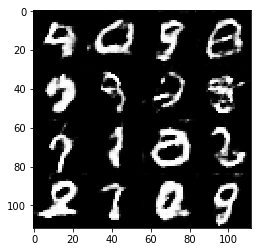

Epoch 2/2... Discriminator Loss: 0.5004... Generator Loss: 3.4910
Epoch 2/2... Discriminator Loss: 0.5013... Generator Loss: 3.8538
Epoch 2/2... Discriminator Loss: 0.5358... Generator Loss: 3.0673
Epoch 2/2... Discriminator Loss: 0.5266... Generator Loss: 3.2657
Epoch 2/2... Discriminator Loss: 0.5528... Generator Loss: 4.2988
Epoch 2/2... Discriminator Loss: 0.5406... Generator Loss: 4.0323
Epoch 2/2... Discriminator Loss: 0.4932... Generator Loss: 4.3724
Epoch 2/2... Discriminator Loss: 0.4940... Generator Loss: 3.8838
Epoch 2/2... Discriminator Loss: 0.5270... Generator Loss: 4.5437
Epoch 2/2... Discriminator Loss: 0.6038... Generator Loss: 3.1937


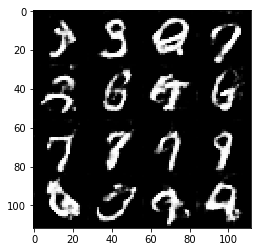

Epoch 2/2... Discriminator Loss: 0.4995... Generator Loss: 4.1618
Epoch 2/2... Discriminator Loss: 0.6856... Generator Loss: 5.5314
Epoch 2/2... Discriminator Loss: 0.5755... Generator Loss: 2.7910
Epoch 2/2... Discriminator Loss: 0.5864... Generator Loss: 5.4076
Epoch 2/2... Discriminator Loss: 0.4924... Generator Loss: 3.5071
Epoch 2/2... Discriminator Loss: 0.5791... Generator Loss: 4.1778
Epoch 2/2... Discriminator Loss: 0.5015... Generator Loss: 3.3835
Epoch 2/2... Discriminator Loss: 0.5005... Generator Loss: 4.0224
Epoch 2/2... Discriminator Loss: 0.4908... Generator Loss: 3.7078
Epoch 2/2... Discriminator Loss: 0.5200... Generator Loss: 3.4011


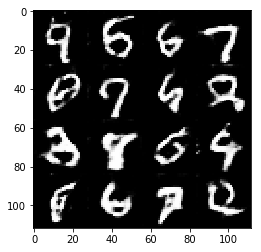

Epoch 2/2... Discriminator Loss: 0.6978... Generator Loss: 4.8762
Epoch 2/2... Discriminator Loss: 0.4964... Generator Loss: 3.6484
Epoch 2/2... Discriminator Loss: 0.4958... Generator Loss: 3.8243
Epoch 2/2... Discriminator Loss: 0.5651... Generator Loss: 3.3846
Epoch 2/2... Discriminator Loss: 0.5016... Generator Loss: 4.1028
Epoch 2/2... Discriminator Loss: 0.5294... Generator Loss: 3.8617
Epoch 2/2... Discriminator Loss: 0.4967... Generator Loss: 3.8820
Epoch 2/2... Discriminator Loss: 0.5202... Generator Loss: 3.6213
Epoch 2/2... Discriminator Loss: 0.5254... Generator Loss: 3.9233
Epoch 2/2... Discriminator Loss: 0.5014... Generator Loss: 3.5486


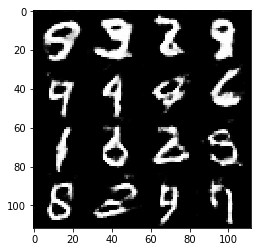

Epoch 2/2... Discriminator Loss: 0.5479... Generator Loss: 4.1036
Epoch 2/2... Discriminator Loss: 0.5613... Generator Loss: 4.3912
Epoch 2/2... Discriminator Loss: 0.5077... Generator Loss: 3.3336
Epoch 2/2... Discriminator Loss: 0.5071... Generator Loss: 4.3330
Epoch 2/2... Discriminator Loss: 0.4802... Generator Loss: 4.4941
Epoch 2/2... Discriminator Loss: 0.5894... Generator Loss: 4.5285
Epoch 2/2... Discriminator Loss: 0.5508... Generator Loss: 3.1536
Epoch 2/2... Discriminator Loss: 0.5035... Generator Loss: 3.3495
Epoch 2/2... Discriminator Loss: 0.5277... Generator Loss: 3.7063
Epoch 2/2... Discriminator Loss: 0.5146... Generator Loss: 3.6931


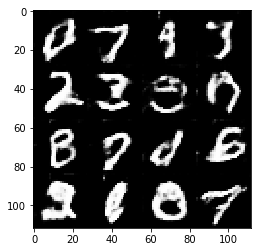

Epoch 2/2... Discriminator Loss: 0.4942... Generator Loss: 3.7274
Epoch 2/2... Discriminator Loss: 0.4869... Generator Loss: 3.5178
Epoch 2/2... Discriminator Loss: 0.4992... Generator Loss: 3.4148
Epoch 2/2... Discriminator Loss: 0.5020... Generator Loss: 3.9655
Epoch 2/2... Discriminator Loss: 0.4989... Generator Loss: 3.4497
Epoch 2/2... Discriminator Loss: 0.5014... Generator Loss: 3.6221
Epoch 2/2... Discriminator Loss: 0.5508... Generator Loss: 4.4638
Epoch 2/2... Discriminator Loss: 0.5348... Generator Loss: 4.0885
Epoch 2/2... Discriminator Loss: 0.5005... Generator Loss: 3.8398
Epoch 2/2... Discriminator Loss: 0.5629... Generator Loss: 4.1482


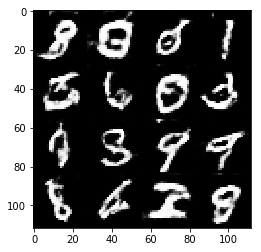

Epoch 2/2... Discriminator Loss: 0.5362... Generator Loss: 4.3608
Epoch 2/2... Discriminator Loss: 0.4915... Generator Loss: 3.8218
Epoch 2/2... Discriminator Loss: 0.5030... Generator Loss: 3.9008
Epoch 2/2... Discriminator Loss: 0.5086... Generator Loss: 3.5772
Epoch 2/2... Discriminator Loss: 0.4909... Generator Loss: 3.7059
Epoch 2/2... Discriminator Loss: 0.4954... Generator Loss: 4.4621
Epoch 2/2... Discriminator Loss: 0.5201... Generator Loss: 3.4521
Epoch 2/2... Discriminator Loss: 0.5094... Generator Loss: 3.2474
Epoch 2/2... Discriminator Loss: 0.5034... Generator Loss: 3.7251
Epoch 2/2... Discriminator Loss: 0.5571... Generator Loss: 3.4667


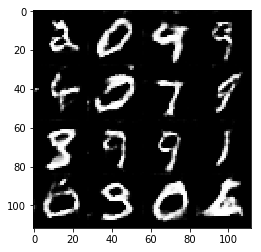

Epoch 2/2... Discriminator Loss: 0.4967... Generator Loss: 4.0400
Epoch 2/2... Discriminator Loss: 0.5081... Generator Loss: 3.9017
Epoch 2/2... Discriminator Loss: 0.6202... Generator Loss: 4.8908
Epoch 2/2... Discriminator Loss: 0.4997... Generator Loss: 3.8399
Epoch 2/2... Discriminator Loss: 0.5406... Generator Loss: 4.4648
Epoch 2/2... Discriminator Loss: 0.4835... Generator Loss: 4.0493
Epoch 2/2... Discriminator Loss: 0.5007... Generator Loss: 3.7770
Epoch 2/2... Discriminator Loss: 0.5736... Generator Loss: 3.0941
Epoch 2/2... Discriminator Loss: 0.5069... Generator Loss: 4.5957
Epoch 2/2... Discriminator Loss: 0.5099... Generator Loss: 3.4836


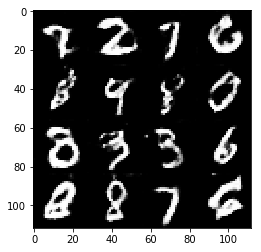

Epoch 2/2... Discriminator Loss: 0.4984... Generator Loss: 4.3382
Epoch 2/2... Discriminator Loss: 0.5292... Generator Loss: 3.0599
Epoch 2/2... Discriminator Loss: 0.4945... Generator Loss: 3.8063
Epoch 2/2... Discriminator Loss: 0.5182... Generator Loss: 3.4562
Epoch 2/2... Discriminator Loss: 0.5011... Generator Loss: 4.3290
Epoch 2/2... Discriminator Loss: 0.5221... Generator Loss: 4.1593
Epoch 2/2... Discriminator Loss: 0.5003... Generator Loss: 3.5748
Epoch 2/2... Discriminator Loss: 0.5000... Generator Loss: 3.9674
Epoch 2/2... Discriminator Loss: 0.5596... Generator Loss: 3.1330
Epoch 2/2... Discriminator Loss: 0.5536... Generator Loss: 4.4660


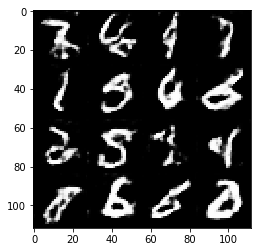

Epoch 2/2... Discriminator Loss: 0.4960... Generator Loss: 3.7071
Epoch 2/2... Discriminator Loss: 0.6484... Generator Loss: 5.0325
Epoch 2/2... Discriminator Loss: 0.5149... Generator Loss: 3.2450
Epoch 2/2... Discriminator Loss: 0.4895... Generator Loss: 3.8356
Epoch 2/2... Discriminator Loss: 0.5140... Generator Loss: 3.5331
Epoch 2/2... Discriminator Loss: 0.5003... Generator Loss: 3.6339
Epoch 2/2... Discriminator Loss: 0.5059... Generator Loss: 3.3809
Epoch 2/2... Discriminator Loss: 0.5014... Generator Loss: 3.5271
Epoch 2/2... Discriminator Loss: 0.5310... Generator Loss: 4.0257
Epoch 2/2... Discriminator Loss: 0.5117... Generator Loss: 3.4136


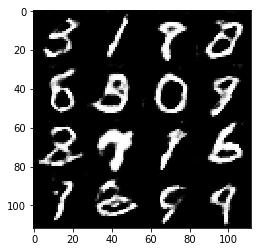

Epoch 2/2... Discriminator Loss: 0.6072... Generator Loss: 3.0652
Epoch 2/2... Discriminator Loss: 0.5311... Generator Loss: 3.8561
Epoch 2/2... Discriminator Loss: 0.4942... Generator Loss: 4.1808
Epoch 2/2... Discriminator Loss: 0.5345... Generator Loss: 4.1706
Epoch 2/2... Discriminator Loss: 0.6106... Generator Loss: 4.4342
Epoch 2/2... Discriminator Loss: 0.5262... Generator Loss: 3.3344
Epoch 2/2... Discriminator Loss: 0.5477... Generator Loss: 3.5486
Epoch 2/2... Discriminator Loss: 0.5159... Generator Loss: 3.7239
Epoch 2/2... Discriminator Loss: 0.5390... Generator Loss: 3.9697
Epoch 2/2... Discriminator Loss: 0.5096... Generator Loss: 3.5851


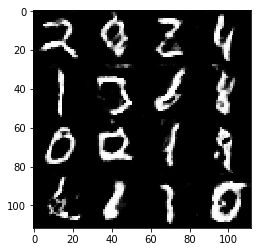

Epoch 2/2... Discriminator Loss: 0.5327... Generator Loss: 4.2530
Epoch 2/2... Discriminator Loss: 0.4948... Generator Loss: 4.2003
Epoch 2/2... Discriminator Loss: 0.5193... Generator Loss: 3.9588
Epoch 2/2... Discriminator Loss: 0.4972... Generator Loss: 3.5518
Epoch 2/2... Discriminator Loss: 0.5077... Generator Loss: 3.4586
Epoch 2/2... Discriminator Loss: 0.5006... Generator Loss: 3.3335
Epoch 2/2... Discriminator Loss: 0.4939... Generator Loss: 3.7344
Epoch 2/2... Discriminator Loss: 0.5394... Generator Loss: 3.9089
Epoch 2/2... Discriminator Loss: 0.5391... Generator Loss: 3.2270
Epoch 2/2... Discriminator Loss: 0.5053... Generator Loss: 3.4946


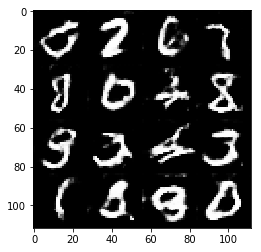

Epoch 2/2... Discriminator Loss: 0.5236... Generator Loss: 3.3833
Epoch 2/2... Discriminator Loss: 0.4921... Generator Loss: 4.1297
Epoch 2/2... Discriminator Loss: 0.5548... Generator Loss: 4.5171
Epoch 2/2... Discriminator Loss: 0.5023... Generator Loss: 3.8214
Epoch 2/2... Discriminator Loss: 0.6196... Generator Loss: 4.7928
Epoch 2/2... Discriminator Loss: 0.5062... Generator Loss: 3.3607
Epoch 2/2... Discriminator Loss: 0.5127... Generator Loss: 3.6617
Epoch 2/2... Discriminator Loss: 0.4995... Generator Loss: 3.4812
Epoch 2/2... Discriminator Loss: 0.4968... Generator Loss: 3.8697
Epoch 2/2... Discriminator Loss: 0.4962... Generator Loss: 3.8882


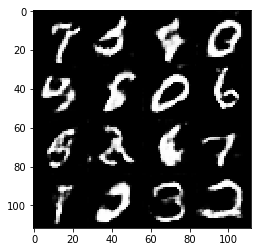

Epoch 2/2... Discriminator Loss: 0.4866... Generator Loss: 3.9605
Epoch 2/2... Discriminator Loss: 0.5076... Generator Loss: 3.0932
Epoch 2/2... Discriminator Loss: 0.5373... Generator Loss: 3.5382
Epoch 2/2... Discriminator Loss: 0.5064... Generator Loss: 4.3646
Epoch 2/2... Discriminator Loss: 0.4861... Generator Loss: 4.0215
Epoch 2/2... Discriminator Loss: 0.5205... Generator Loss: 3.8134
Epoch 2/2... Discriminator Loss: 0.5310... Generator Loss: 4.7454
Epoch 2/2... Discriminator Loss: 0.4989... Generator Loss: 3.5883
Epoch 2/2... Discriminator Loss: 0.4957... Generator Loss: 4.1630
Epoch 2/2... Discriminator Loss: 0.4998... Generator Loss: 3.4690


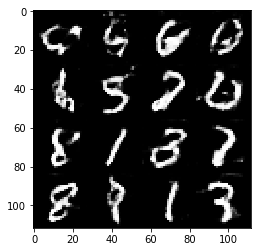

Epoch 2/2... Discriminator Loss: 0.5060... Generator Loss: 4.3856
Epoch 2/2... Discriminator Loss: 0.5006... Generator Loss: 3.7199
Epoch 2/2... Discriminator Loss: 0.5234... Generator Loss: 4.7092
Epoch 2/2... Discriminator Loss: 0.5179... Generator Loss: 4.4065
Epoch 2/2... Discriminator Loss: 0.4893... Generator Loss: 4.1067
Epoch 2/2... Discriminator Loss: 0.5658... Generator Loss: 4.5283
Epoch 2/2... Discriminator Loss: 0.5547... Generator Loss: 4.8055
Epoch 2/2... Discriminator Loss: 0.5038... Generator Loss: 3.7741
Epoch 2/2... Discriminator Loss: 0.4913... Generator Loss: 4.1167
Epoch 2/2... Discriminator Loss: 0.5039... Generator Loss: 3.1691


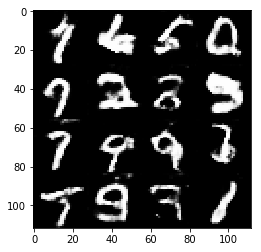

Epoch 2/2... Discriminator Loss: 0.4924... Generator Loss: 3.8242
Epoch 2/2... Discriminator Loss: 0.5532... Generator Loss: 2.9866
Epoch 2/2... Discriminator Loss: 0.5098... Generator Loss: 3.4538
Epoch 2/2... Discriminator Loss: 0.4835... Generator Loss: 4.0825
Epoch 2/2... Discriminator Loss: 0.4932... Generator Loss: 3.8599
Epoch 2/2... Discriminator Loss: 0.5074... Generator Loss: 3.7605
Epoch 2/2... Discriminator Loss: 0.4828... Generator Loss: 3.8529
Epoch 2/2... Discriminator Loss: 0.4993... Generator Loss: 3.9355
Epoch 2/2... Discriminator Loss: 0.5335... Generator Loss: 3.6679
Epoch 2/2... Discriminator Loss: 0.4994... Generator Loss: 4.3591


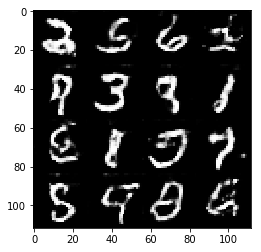

Epoch 2/2... Discriminator Loss: 0.4953... Generator Loss: 4.2215
Epoch 2/2... Discriminator Loss: 0.4991... Generator Loss: 3.5477
Epoch 2/2... Discriminator Loss: 0.5182... Generator Loss: 3.7732
Epoch 2/2... Discriminator Loss: 0.5285... Generator Loss: 3.5130
Epoch 2/2... Discriminator Loss: 0.5686... Generator Loss: 4.5254
Epoch 2/2... Discriminator Loss: 0.5336... Generator Loss: 4.1335
Epoch 2/2... Discriminator Loss: 0.5141... Generator Loss: 3.7411
Epoch 2/2... Discriminator Loss: 0.5052... Generator Loss: 3.8556
Epoch 2/2... Discriminator Loss: 0.5061... Generator Loss: 3.9081
Epoch 2/2... Discriminator Loss: 0.4927... Generator Loss: 3.9382


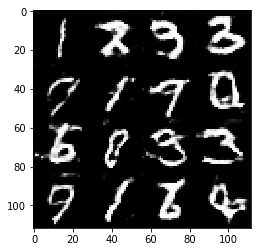

Epoch 2/2... Discriminator Loss: 0.5087... Generator Loss: 4.3279
Epoch 2/2... Discriminator Loss: 0.5032... Generator Loss: 4.1247
Epoch 2/2... Discriminator Loss: 0.5028... Generator Loss: 3.8200
Epoch 2/2... Discriminator Loss: 0.5125... Generator Loss: 4.3529
Epoch 2/2... Discriminator Loss: 0.8505... Generator Loss: 5.7547
Epoch 2/2... Discriminator Loss: 0.5226... Generator Loss: 3.5811
Epoch 2/2... Discriminator Loss: 0.4966... Generator Loss: 3.9299
Epoch 2/2... Discriminator Loss: 0.4969... Generator Loss: 3.8877
Epoch 2/2... Discriminator Loss: 0.5037... Generator Loss: 3.8887
Epoch 2/2... Discriminator Loss: 0.5041... Generator Loss: 3.1661


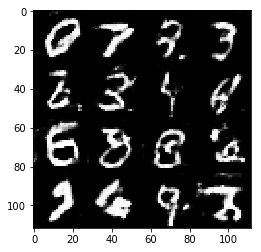

Epoch 2/2... Discriminator Loss: 0.5394... Generator Loss: 3.4349
Epoch 2/2... Discriminator Loss: 0.5000... Generator Loss: 3.8776
Epoch 2/2... Discriminator Loss: 0.5060... Generator Loss: 3.9270
Epoch 2/2... Discriminator Loss: 0.4944... Generator Loss: 3.4892
Epoch 2/2... Discriminator Loss: 0.5001... Generator Loss: 3.5766
Epoch 2/2... Discriminator Loss: 0.7728... Generator Loss: 5.5332
Epoch 2/2... Discriminator Loss: 0.4933... Generator Loss: 3.3342
Epoch 2/2... Discriminator Loss: 0.5045... Generator Loss: 3.4759
Epoch 2/2... Discriminator Loss: 0.5323... Generator Loss: 4.6008
Epoch 2/2... Discriminator Loss: 0.4933... Generator Loss: 3.8664


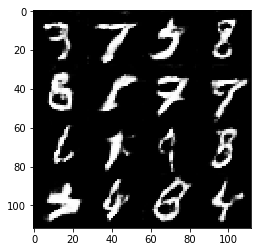

Epoch 2/2... Discriminator Loss: 0.5257... Generator Loss: 3.3865
Epoch 2/2... Discriminator Loss: 0.5073... Generator Loss: 3.2157
Epoch 2/2... Discriminator Loss: 0.4907... Generator Loss: 3.7278
Epoch 2/2... Discriminator Loss: 0.5181... Generator Loss: 3.6162
Epoch 2/2... Discriminator Loss: 0.4906... Generator Loss: 3.8877
Epoch 2/2... Discriminator Loss: 0.5084... Generator Loss: 4.3044
Epoch 2/2... Discriminator Loss: 0.4928... Generator Loss: 4.6811
Epoch 2/2... Discriminator Loss: 0.6334... Generator Loss: 4.8087
Epoch 2/2... Discriminator Loss: 0.4861... Generator Loss: 3.7173
Epoch 2/2... Discriminator Loss: 0.5475... Generator Loss: 4.7460


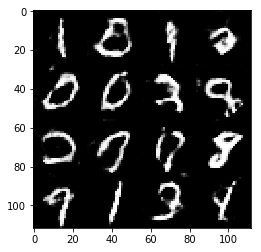

Epoch 2/2... Discriminator Loss: 0.5190... Generator Loss: 3.7180
Epoch 2/2... Discriminator Loss: 0.5147... Generator Loss: 4.0413
Epoch 2/2... Discriminator Loss: 0.5188... Generator Loss: 3.8603
Epoch 2/2... Discriminator Loss: 0.5061... Generator Loss: 3.8454
Epoch 2/2... Discriminator Loss: 0.5115... Generator Loss: 3.4832
Epoch 2/2... Discriminator Loss: 0.5883... Generator Loss: 4.7871
Epoch 2/2... Discriminator Loss: 0.5006... Generator Loss: 4.2327
Epoch 2/2... Discriminator Loss: 0.4938... Generator Loss: 3.6611
Epoch 2/2... Discriminator Loss: 0.5252... Generator Loss: 3.0492
Epoch 2/2... Discriminator Loss: 0.5494... Generator Loss: 3.6062


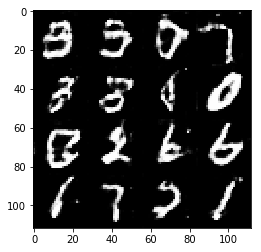

Epoch 2/2... Discriminator Loss: 0.5097... Generator Loss: 3.1724
Epoch 2/2... Discriminator Loss: 0.5103... Generator Loss: 3.3338
Epoch 2/2... Discriminator Loss: 0.5182... Generator Loss: 3.5320
Epoch 2/2... Discriminator Loss: 0.4935... Generator Loss: 4.0547
Epoch 2/2... Discriminator Loss: 0.6036... Generator Loss: 4.9588
Epoch 2/2... Discriminator Loss: 0.5460... Generator Loss: 3.3736
Epoch 2/2... Discriminator Loss: 0.5016... Generator Loss: 3.7023
Epoch 2/2... Discriminator Loss: 0.5005... Generator Loss: 4.4719
Epoch 2/2... Discriminator Loss: 0.5124... Generator Loss: 3.3309
Epoch 2/2... Discriminator Loss: 0.5233... Generator Loss: 3.2494


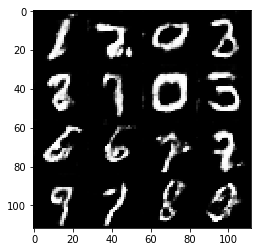

Epoch 2/2... Discriminator Loss: 0.4757... Generator Loss: 4.2459
Epoch 2/2... Discriminator Loss: 0.4912... Generator Loss: 3.9476
Epoch 2/2... Discriminator Loss: 0.5615... Generator Loss: 4.7073
Epoch 2/2... Discriminator Loss: 0.5185... Generator Loss: 4.3920
Epoch 2/2... Discriminator Loss: 0.5121... Generator Loss: 3.9665
Epoch 2/2... Discriminator Loss: 0.4966... Generator Loss: 3.8378
Epoch 2/2... Discriminator Loss: 0.5094... Generator Loss: 4.1351
Epoch 2/2... Discriminator Loss: 0.5051... Generator Loss: 3.4283
Epoch 2/2... Discriminator Loss: 0.5115... Generator Loss: 3.7387
Epoch 2/2... Discriminator Loss: 0.5053... Generator Loss: 3.8926


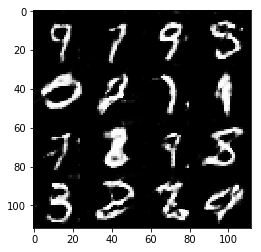

Epoch 2/2... Discriminator Loss: 0.4860... Generator Loss: 3.8216
Epoch 2/2... Discriminator Loss: 0.5317... Generator Loss: 3.8196
Epoch 2/2... Discriminator Loss: 0.5155... Generator Loss: 2.8524
Epoch 2/2... Discriminator Loss: 0.4880... Generator Loss: 4.6105
Epoch 2/2... Discriminator Loss: 0.5046... Generator Loss: 3.7548
Epoch 2/2... Discriminator Loss: 0.5051... Generator Loss: 3.3534
Epoch 2/2... Discriminator Loss: 0.5039... Generator Loss: 3.5490
Epoch 2/2... Discriminator Loss: 0.5064... Generator Loss: 3.6401
Epoch 2/2... Discriminator Loss: 0.4977... Generator Loss: 4.5314
Epoch 2/2... Discriminator Loss: 0.5070... Generator Loss: 4.1570


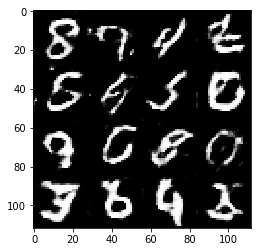

Epoch 2/2... Discriminator Loss: 0.4947... Generator Loss: 4.2420
Epoch 2/2... Discriminator Loss: 0.5120... Generator Loss: 3.1574
Epoch 2/2... Discriminator Loss: 0.4989... Generator Loss: 3.9858
Epoch 2/2... Discriminator Loss: 0.4963... Generator Loss: 3.8732
Epoch 2/2... Discriminator Loss: 0.4959... Generator Loss: 3.9747
Epoch 2/2... Discriminator Loss: 0.5385... Generator Loss: 3.2707
Epoch 2/2... Discriminator Loss: 0.5383... Generator Loss: 3.9360
Epoch 2/2... Discriminator Loss: 0.5222... Generator Loss: 3.9495
Epoch 2/2... Discriminator Loss: 0.5339... Generator Loss: 2.9890
Epoch 2/2... Discriminator Loss: 0.5157... Generator Loss: 4.0403


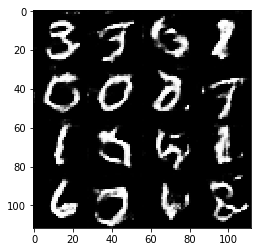

Epoch 2/2... Discriminator Loss: 0.5556... Generator Loss: 4.8589
Epoch 2/2... Discriminator Loss: 0.4978... Generator Loss: 3.8767
Epoch 2/2... Discriminator Loss: 0.5249... Generator Loss: 3.1797
Epoch 2/2... Discriminator Loss: 0.4892... Generator Loss: 4.1355
Epoch 2/2... Discriminator Loss: 0.5123... Generator Loss: 3.6231
Epoch 2/2... Discriminator Loss: 0.5117... Generator Loss: 4.5047
Epoch 2/2... Discriminator Loss: 0.5379... Generator Loss: 4.1089
Epoch 2/2... Discriminator Loss: 0.5184... Generator Loss: 5.0876
Epoch 2/2... Discriminator Loss: 0.4984... Generator Loss: 3.6765
Epoch 2/2... Discriminator Loss: 0.4919... Generator Loss: 3.5521


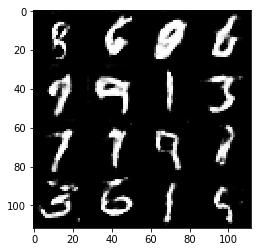

Epoch 2/2... Discriminator Loss: 0.4907... Generator Loss: 3.7911
Epoch 2/2... Discriminator Loss: 0.5866... Generator Loss: 5.1321
Epoch 2/2... Discriminator Loss: 0.5249... Generator Loss: 3.4936
Epoch 2/2... Discriminator Loss: 0.5629... Generator Loss: 3.1509
Epoch 2/2... Discriminator Loss: 0.4972... Generator Loss: 4.4378
Epoch 2/2... Discriminator Loss: 0.4848... Generator Loss: 4.3620
Epoch 2/2... Discriminator Loss: 0.6900... Generator Loss: 5.1034
Epoch 2/2... Discriminator Loss: 0.5299... Generator Loss: 3.5291
Epoch 2/2... Discriminator Loss: 0.5167... Generator Loss: 3.7115
Epoch 2/2... Discriminator Loss: 0.5065... Generator Loss: 3.6284


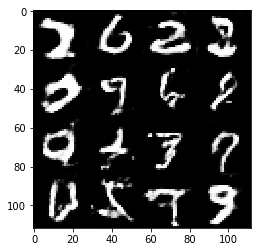

Epoch 2/2... Discriminator Loss: 0.5034... Generator Loss: 3.8856
Epoch 2/2... Discriminator Loss: 0.5121... Generator Loss: 3.6190
Epoch 2/2... Discriminator Loss: 0.5640... Generator Loss: 4.5084
Epoch 2/2... Discriminator Loss: 0.5575... Generator Loss: 4.5747
Epoch 2/2... Discriminator Loss: 0.4920... Generator Loss: 3.8443
Epoch 2/2... Discriminator Loss: 0.5254... Generator Loss: 3.8473
Epoch 2/2... Discriminator Loss: 0.5616... Generator Loss: 4.3797
Epoch 2/2... Discriminator Loss: 0.5003... Generator Loss: 3.7786
Epoch 2/2... Discriminator Loss: 0.5007... Generator Loss: 3.6498
Epoch 2/2... Discriminator Loss: 0.5396... Generator Loss: 3.2235


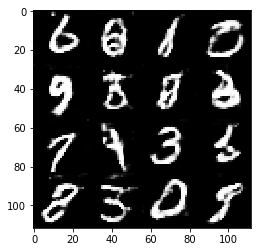

Epoch 2/2... Discriminator Loss: 0.4887... Generator Loss: 3.7249
Epoch 2/2... Discriminator Loss: 0.5310... Generator Loss: 4.3622
Epoch 2/2... Discriminator Loss: 0.5783... Generator Loss: 5.0707
Epoch 2/2... Discriminator Loss: 0.4918... Generator Loss: 3.4286
Epoch 2/2... Discriminator Loss: 0.4963... Generator Loss: 4.1707
Epoch 2/2... Discriminator Loss: 0.4929... Generator Loss: 4.2626
Epoch 2/2... Discriminator Loss: 0.4943... Generator Loss: 3.9331
Epoch 2/2... Discriminator Loss: 0.4858... Generator Loss: 4.4417
Epoch 2/2... Discriminator Loss: 0.5126... Generator Loss: 3.6832
Epoch 2/2... Discriminator Loss: 0.4961... Generator Loss: 4.3175


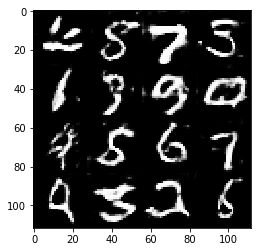

Epoch 2/2... Discriminator Loss: 0.5719... Generator Loss: 5.0263


In [12]:
batch_size = 16
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3172... Generator Loss: 7.8122
Epoch 1/1... Discriminator Loss: 0.2100... Generator Loss: 4.3967
Epoch 1/1... Discriminator Loss: 0.3399... Generator Loss: 7.5100
Epoch 1/1... Discriminator Loss: 0.1849... Generator Loss: 5.0574
Epoch 1/1... Discriminator Loss: 0.1859... Generator Loss: 4.8106
Epoch 1/1... Discriminator Loss: 0.1785... Generator Loss: 5.2099
Epoch 1/1... Discriminator Loss: 0.1841... Generator Loss: 5.4516
Epoch 1/1... Discriminator Loss: 0.1740... Generator Loss: 5.3838
Epoch 1/1... Discriminator Loss: 0.1722... Generator Loss: 5.6316


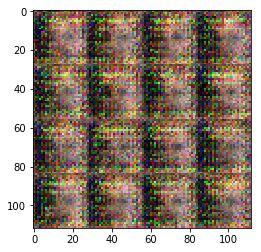

Epoch 1/1... Discriminator Loss: 0.1945... Generator Loss: 7.3883
Epoch 1/1... Discriminator Loss: 0.1749... Generator Loss: 6.7462
Epoch 1/1... Discriminator Loss: 0.1804... Generator Loss: 6.8162
Epoch 1/1... Discriminator Loss: 0.1755... Generator Loss: 5.5840
Epoch 1/1... Discriminator Loss: 0.1855... Generator Loss: 4.3184
Epoch 1/1... Discriminator Loss: 0.1956... Generator Loss: 5.2734
Epoch 1/1... Discriminator Loss: 0.1977... Generator Loss: 5.6066
Epoch 1/1... Discriminator Loss: 0.1848... Generator Loss: 4.3321
Epoch 1/1... Discriminator Loss: 0.1800... Generator Loss: 5.0517
Epoch 1/1... Discriminator Loss: 0.1798... Generator Loss: 5.3060


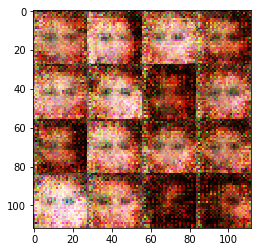

Epoch 1/1... Discriminator Loss: 0.1853... Generator Loss: 4.3635
Epoch 1/1... Discriminator Loss: 0.2286... Generator Loss: 8.1865
Epoch 1/1... Discriminator Loss: 0.1777... Generator Loss: 4.9630
Epoch 1/1... Discriminator Loss: 0.2207... Generator Loss: 6.2508
Epoch 1/1... Discriminator Loss: 0.1825... Generator Loss: 4.9517
Epoch 1/1... Discriminator Loss: 0.1780... Generator Loss: 5.2895
Epoch 1/1... Discriminator Loss: 0.1879... Generator Loss: 4.1631
Epoch 1/1... Discriminator Loss: 0.2244... Generator Loss: 6.2600
Epoch 1/1... Discriminator Loss: 0.1824... Generator Loss: 4.7638
Epoch 1/1... Discriminator Loss: 0.1997... Generator Loss: 5.4374


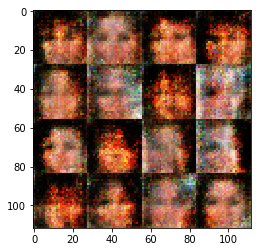

Epoch 1/1... Discriminator Loss: 0.1899... Generator Loss: 4.2331
Epoch 1/1... Discriminator Loss: 0.1965... Generator Loss: 5.4200
Epoch 1/1... Discriminator Loss: 0.1976... Generator Loss: 4.9940
Epoch 1/1... Discriminator Loss: 0.1889... Generator Loss: 4.1878
Epoch 1/1... Discriminator Loss: 0.1955... Generator Loss: 5.4544
Epoch 1/1... Discriminator Loss: 0.1980... Generator Loss: 5.3495
Epoch 1/1... Discriminator Loss: 0.1898... Generator Loss: 4.2995
Epoch 1/1... Discriminator Loss: 0.1917... Generator Loss: 5.0260
Epoch 1/1... Discriminator Loss: 0.1858... Generator Loss: 4.3315
Epoch 1/1... Discriminator Loss: 0.1944... Generator Loss: 3.9412


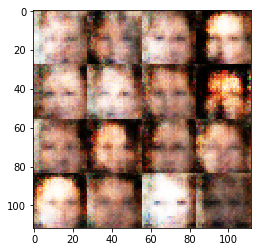

Epoch 1/1... Discriminator Loss: 0.1858... Generator Loss: 4.5784
Epoch 1/1... Discriminator Loss: 0.1905... Generator Loss: 4.4796
Epoch 1/1... Discriminator Loss: 0.1868... Generator Loss: 4.3055
Epoch 1/1... Discriminator Loss: 0.1873... Generator Loss: 4.7290
Epoch 1/1... Discriminator Loss: 0.1879... Generator Loss: 4.3833
Epoch 1/1... Discriminator Loss: 0.1860... Generator Loss: 4.6151
Epoch 1/1... Discriminator Loss: 0.2184... Generator Loss: 3.2954
Epoch 1/1... Discriminator Loss: 0.1903... Generator Loss: 3.9492
Epoch 1/1... Discriminator Loss: 0.1863... Generator Loss: 4.3476
Epoch 1/1... Discriminator Loss: 0.1908... Generator Loss: 4.6791


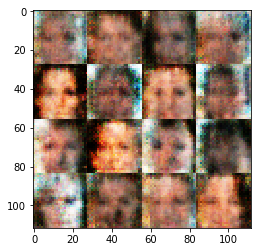

Epoch 1/1... Discriminator Loss: 0.1854... Generator Loss: 4.4612
Epoch 1/1... Discriminator Loss: 0.1929... Generator Loss: 4.4672
Epoch 1/1... Discriminator Loss: 0.2055... Generator Loss: 3.5197
Epoch 1/1... Discriminator Loss: 0.1865... Generator Loss: 4.3987
Epoch 1/1... Discriminator Loss: 0.1879... Generator Loss: 4.1114
Epoch 1/1... Discriminator Loss: 0.1870... Generator Loss: 4.1642
Epoch 1/1... Discriminator Loss: 0.1901... Generator Loss: 4.0629
Epoch 1/1... Discriminator Loss: 0.1892... Generator Loss: 4.3877
Epoch 1/1... Discriminator Loss: 0.1844... Generator Loss: 4.6696
Epoch 1/1... Discriminator Loss: 0.1953... Generator Loss: 3.7431


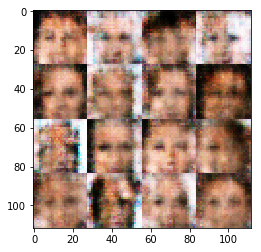

Epoch 1/1... Discriminator Loss: 0.1917... Generator Loss: 4.6635
Epoch 1/1... Discriminator Loss: 0.1887... Generator Loss: 4.1911
Epoch 1/1... Discriminator Loss: 0.1852... Generator Loss: 4.4587
Epoch 1/1... Discriminator Loss: 0.1889... Generator Loss: 4.5776
Epoch 1/1... Discriminator Loss: 0.1948... Generator Loss: 3.8290
Epoch 1/1... Discriminator Loss: 0.1904... Generator Loss: 4.2478
Epoch 1/1... Discriminator Loss: 0.1827... Generator Loss: 4.8989
Epoch 1/1... Discriminator Loss: 0.1911... Generator Loss: 4.0287
Epoch 1/1... Discriminator Loss: 0.1855... Generator Loss: 4.3039
Epoch 1/1... Discriminator Loss: 0.1979... Generator Loss: 4.6553


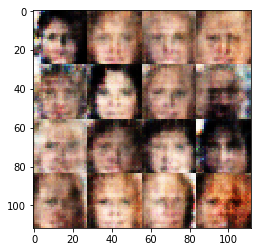

Epoch 1/1... Discriminator Loss: 0.1865... Generator Loss: 4.6702
Epoch 1/1... Discriminator Loss: 0.1880... Generator Loss: 4.1464
Epoch 1/1... Discriminator Loss: 0.2000... Generator Loss: 4.0126
Epoch 1/1... Discriminator Loss: 0.1911... Generator Loss: 3.9517
Epoch 1/1... Discriminator Loss: 0.2021... Generator Loss: 5.2488
Epoch 1/1... Discriminator Loss: 0.1910... Generator Loss: 4.7918
Epoch 1/1... Discriminator Loss: 0.1949... Generator Loss: 3.6801
Epoch 1/1... Discriminator Loss: 0.1917... Generator Loss: 4.6899
Epoch 1/1... Discriminator Loss: 0.1905... Generator Loss: 3.9025
Epoch 1/1... Discriminator Loss: 0.1858... Generator Loss: 4.7315


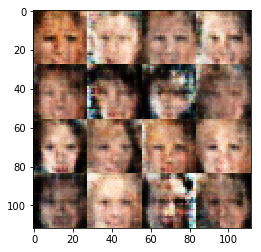

Epoch 1/1... Discriminator Loss: 0.1857... Generator Loss: 4.4687
Epoch 1/1... Discriminator Loss: 0.1840... Generator Loss: 4.5386
Epoch 1/1... Discriminator Loss: 0.1950... Generator Loss: 5.1274
Epoch 1/1... Discriminator Loss: 0.1887... Generator Loss: 3.9177
Epoch 1/1... Discriminator Loss: 0.1913... Generator Loss: 3.9847
Epoch 1/1... Discriminator Loss: 0.1887... Generator Loss: 4.0611
Epoch 1/1... Discriminator Loss: 0.1903... Generator Loss: 4.6935
Epoch 1/1... Discriminator Loss: 0.1936... Generator Loss: 4.6824
Epoch 1/1... Discriminator Loss: 0.1886... Generator Loss: 4.5575
Epoch 1/1... Discriminator Loss: 0.1895... Generator Loss: 4.1277


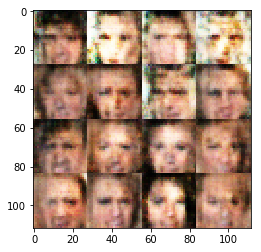

Epoch 1/1... Discriminator Loss: 0.1902... Generator Loss: 3.8468
Epoch 1/1... Discriminator Loss: 0.2125... Generator Loss: 5.4562
Epoch 1/1... Discriminator Loss: 0.1909... Generator Loss: 4.6667
Epoch 1/1... Discriminator Loss: 0.1936... Generator Loss: 3.9474
Epoch 1/1... Discriminator Loss: 0.1875... Generator Loss: 4.2204
Epoch 1/1... Discriminator Loss: 0.1888... Generator Loss: 4.0274
Epoch 1/1... Discriminator Loss: 0.1877... Generator Loss: 4.4686
Epoch 1/1... Discriminator Loss: 0.1930... Generator Loss: 3.8509
Epoch 1/1... Discriminator Loss: 0.1903... Generator Loss: 4.1237
Epoch 1/1... Discriminator Loss: 0.1968... Generator Loss: 3.7617


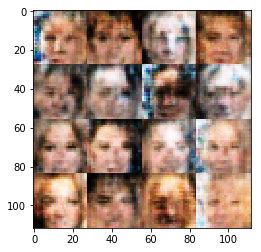

Epoch 1/1... Discriminator Loss: 0.1861... Generator Loss: 4.6244
Epoch 1/1... Discriminator Loss: 0.1864... Generator Loss: 4.8124
Epoch 1/1... Discriminator Loss: 0.1917... Generator Loss: 3.9218
Epoch 1/1... Discriminator Loss: 0.1908... Generator Loss: 5.0960
Epoch 1/1... Discriminator Loss: 0.1897... Generator Loss: 4.5084
Epoch 1/1... Discriminator Loss: 0.1874... Generator Loss: 3.8134
Epoch 1/1... Discriminator Loss: 0.1821... Generator Loss: 4.3102
Epoch 1/1... Discriminator Loss: 0.1828... Generator Loss: 4.5094
Epoch 1/1... Discriminator Loss: 0.1917... Generator Loss: 3.9199
Epoch 1/1... Discriminator Loss: 0.1878... Generator Loss: 4.6317


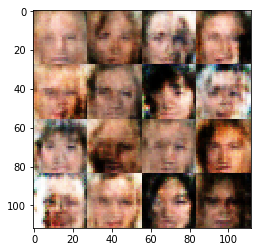

Epoch 1/1... Discriminator Loss: 0.1896... Generator Loss: 3.9267
Epoch 1/1... Discriminator Loss: 0.1900... Generator Loss: 3.8660
Epoch 1/1... Discriminator Loss: 0.1879... Generator Loss: 4.1098
Epoch 1/1... Discriminator Loss: 0.1884... Generator Loss: 4.2713
Epoch 1/1... Discriminator Loss: 0.1879... Generator Loss: 3.8789
Epoch 1/1... Discriminator Loss: 0.1868... Generator Loss: 4.1888
Epoch 1/1... Discriminator Loss: 0.2023... Generator Loss: 5.3206
Epoch 1/1... Discriminator Loss: 0.1877... Generator Loss: 3.9950
Epoch 1/1... Discriminator Loss: 0.1951... Generator Loss: 4.8343
Epoch 1/1... Discriminator Loss: 0.1919... Generator Loss: 3.9662


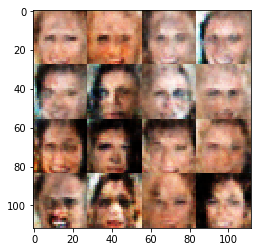

Epoch 1/1... Discriminator Loss: 0.1883... Generator Loss: 4.0932
Epoch 1/1... Discriminator Loss: 0.1866... Generator Loss: 3.8713
Epoch 1/1... Discriminator Loss: 0.1888... Generator Loss: 4.6117
Epoch 1/1... Discriminator Loss: 0.1973... Generator Loss: 3.4788
Epoch 1/1... Discriminator Loss: 0.1915... Generator Loss: 3.8994
Epoch 1/1... Discriminator Loss: 0.1836... Generator Loss: 4.2767
Epoch 1/1... Discriminator Loss: 0.1878... Generator Loss: 4.1967
Epoch 1/1... Discriminator Loss: 0.1891... Generator Loss: 4.0086
Epoch 1/1... Discriminator Loss: 0.1893... Generator Loss: 4.1679
Epoch 1/1... Discriminator Loss: 0.1863... Generator Loss: 4.3691


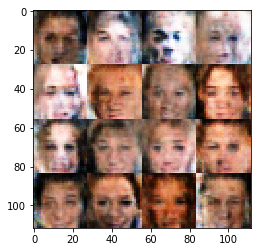

Epoch 1/1... Discriminator Loss: 0.1881... Generator Loss: 4.5142
Epoch 1/1... Discriminator Loss: 0.1904... Generator Loss: 3.9634
Epoch 1/1... Discriminator Loss: 0.1912... Generator Loss: 4.4182
Epoch 1/1... Discriminator Loss: 0.1916... Generator Loss: 4.7357
Epoch 1/1... Discriminator Loss: 0.1880... Generator Loss: 4.3262
Epoch 1/1... Discriminator Loss: 0.1895... Generator Loss: 3.9101
Epoch 1/1... Discriminator Loss: 0.1899... Generator Loss: 4.3429
Epoch 1/1... Discriminator Loss: 0.1864... Generator Loss: 4.0684
Epoch 1/1... Discriminator Loss: 0.1844... Generator Loss: 4.4006
Epoch 1/1... Discriminator Loss: 0.2014... Generator Loss: 3.5988


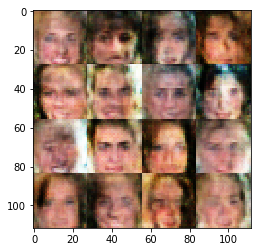

Epoch 1/1... Discriminator Loss: 0.1898... Generator Loss: 3.8871
Epoch 1/1... Discriminator Loss: 0.1885... Generator Loss: 4.0631
Epoch 1/1... Discriminator Loss: 0.1944... Generator Loss: 4.9356
Epoch 1/1... Discriminator Loss: 0.1836... Generator Loss: 4.2600
Epoch 1/1... Discriminator Loss: 0.1934... Generator Loss: 3.7963
Epoch 1/1... Discriminator Loss: 0.1867... Generator Loss: 4.1114
Epoch 1/1... Discriminator Loss: 0.1883... Generator Loss: 4.4505
Epoch 1/1... Discriminator Loss: 0.1855... Generator Loss: 4.2265
Epoch 1/1... Discriminator Loss: 0.1913... Generator Loss: 3.8803
Epoch 1/1... Discriminator Loss: 0.1883... Generator Loss: 4.5151


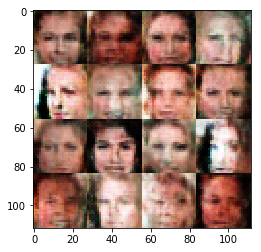

Epoch 1/1... Discriminator Loss: 0.1904... Generator Loss: 3.7678
Epoch 1/1... Discriminator Loss: 0.1954... Generator Loss: 3.8741
Epoch 1/1... Discriminator Loss: 0.1903... Generator Loss: 4.9367
Epoch 1/1... Discriminator Loss: 0.1851... Generator Loss: 4.3949
Epoch 1/1... Discriminator Loss: 0.1887... Generator Loss: 3.9433
Epoch 1/1... Discriminator Loss: 0.1876... Generator Loss: 4.0287
Epoch 1/1... Discriminator Loss: 0.1985... Generator Loss: 5.1102
Epoch 1/1... Discriminator Loss: 0.1943... Generator Loss: 5.0281
Epoch 1/1... Discriminator Loss: 0.1857... Generator Loss: 4.2883
Epoch 1/1... Discriminator Loss: 0.1877... Generator Loss: 3.9627


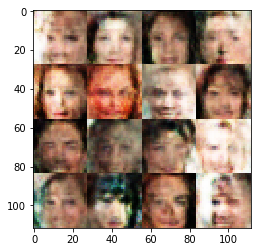

Epoch 1/1... Discriminator Loss: 0.1886... Generator Loss: 4.4715
Epoch 1/1... Discriminator Loss: 0.1896... Generator Loss: 3.9267
Epoch 1/1... Discriminator Loss: 0.1920... Generator Loss: 3.8088
Epoch 1/1... Discriminator Loss: 0.1964... Generator Loss: 3.8155
Epoch 1/1... Discriminator Loss: 0.1926... Generator Loss: 3.7247
Epoch 1/1... Discriminator Loss: 0.1843... Generator Loss: 3.9562
Epoch 1/1... Discriminator Loss: 0.1881... Generator Loss: 3.9466
Epoch 1/1... Discriminator Loss: 0.1856... Generator Loss: 4.4569
Epoch 1/1... Discriminator Loss: 0.1918... Generator Loss: 4.7937
Epoch 1/1... Discriminator Loss: 0.1839... Generator Loss: 4.6379


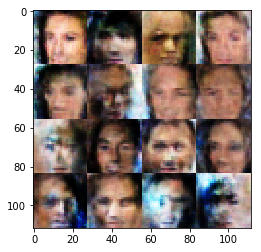

Epoch 1/1... Discriminator Loss: 0.1867... Generator Loss: 3.9656
Epoch 1/1... Discriminator Loss: 0.1853... Generator Loss: 4.0897
Epoch 1/1... Discriminator Loss: 0.1859... Generator Loss: 4.6836
Epoch 1/1... Discriminator Loss: 0.1911... Generator Loss: 4.0300
Epoch 1/1... Discriminator Loss: 0.1844... Generator Loss: 4.2778
Epoch 1/1... Discriminator Loss: 0.1872... Generator Loss: 3.8404
Epoch 1/1... Discriminator Loss: 0.1901... Generator Loss: 4.1740
Epoch 1/1... Discriminator Loss: 0.1894... Generator Loss: 4.7696
Epoch 1/1... Discriminator Loss: 0.1887... Generator Loss: 4.6927
Epoch 1/1... Discriminator Loss: 0.1853... Generator Loss: 4.2904


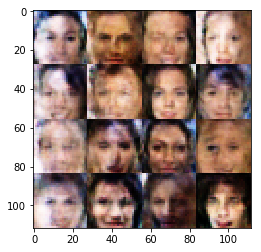

Epoch 1/1... Discriminator Loss: 0.1851... Generator Loss: 4.4322
Epoch 1/1... Discriminator Loss: 0.1863... Generator Loss: 4.6746
Epoch 1/1... Discriminator Loss: 0.1850... Generator Loss: 4.1773
Epoch 1/1... Discriminator Loss: 0.1868... Generator Loss: 4.6527
Epoch 1/1... Discriminator Loss: 0.1932... Generator Loss: 4.1367
Epoch 1/1... Discriminator Loss: 0.1898... Generator Loss: 4.1928
Epoch 1/1... Discriminator Loss: 0.1852... Generator Loss: 4.1454
Epoch 1/1... Discriminator Loss: 0.1894... Generator Loss: 3.8142
Epoch 1/1... Discriminator Loss: 0.1920... Generator Loss: 3.9945
Epoch 1/1... Discriminator Loss: 0.1861... Generator Loss: 4.3170


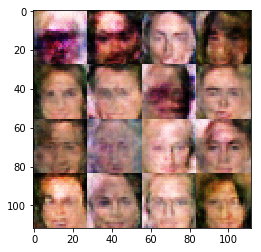

Epoch 1/1... Discriminator Loss: 0.1909... Generator Loss: 4.5334
Epoch 1/1... Discriminator Loss: 0.1895... Generator Loss: 4.5195
Epoch 1/1... Discriminator Loss: 0.1884... Generator Loss: 4.0593
Epoch 1/1... Discriminator Loss: 0.1868... Generator Loss: 4.2289
Epoch 1/1... Discriminator Loss: 0.1970... Generator Loss: 3.7637
Epoch 1/1... Discriminator Loss: 0.1865... Generator Loss: 4.6447
Epoch 1/1... Discriminator Loss: 0.1886... Generator Loss: 3.9331
Epoch 1/1... Discriminator Loss: 0.1859... Generator Loss: 4.2373
Epoch 1/1... Discriminator Loss: 0.1995... Generator Loss: 5.2309
Epoch 1/1... Discriminator Loss: 0.1880... Generator Loss: 4.6504


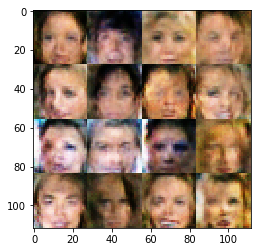

Epoch 1/1... Discriminator Loss: 0.1864... Generator Loss: 3.9802
Epoch 1/1... Discriminator Loss: 0.1873... Generator Loss: 4.0953
Epoch 1/1... Discriminator Loss: 0.1859... Generator Loss: 4.1397
Epoch 1/1... Discriminator Loss: 0.1873... Generator Loss: 3.9152
Epoch 1/1... Discriminator Loss: 0.1854... Generator Loss: 4.2650
Epoch 1/1... Discriminator Loss: 0.1877... Generator Loss: 4.6782
Epoch 1/1... Discriminator Loss: 0.1835... Generator Loss: 4.3602
Epoch 1/1... Discriminator Loss: 0.1996... Generator Loss: 5.0571
Epoch 1/1... Discriminator Loss: 0.1911... Generator Loss: 3.9763
Epoch 1/1... Discriminator Loss: 0.1926... Generator Loss: 4.5522


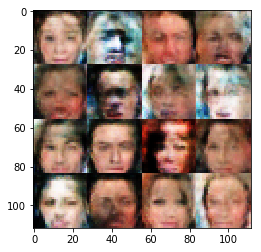

Epoch 1/1... Discriminator Loss: 0.1918... Generator Loss: 4.6003
Epoch 1/1... Discriminator Loss: 0.1887... Generator Loss: 4.7386
Epoch 1/1... Discriminator Loss: 0.1880... Generator Loss: 4.3058
Epoch 1/1... Discriminator Loss: 0.1929... Generator Loss: 4.6487
Epoch 1/1... Discriminator Loss: 0.1883... Generator Loss: 4.2802
Epoch 1/1... Discriminator Loss: 0.1900... Generator Loss: 4.8701
Epoch 1/1... Discriminator Loss: 0.1814... Generator Loss: 4.4384
Epoch 1/1... Discriminator Loss: 0.1880... Generator Loss: 4.4000
Epoch 1/1... Discriminator Loss: 0.1886... Generator Loss: 3.9851
Epoch 1/1... Discriminator Loss: 0.1990... Generator Loss: 5.1037


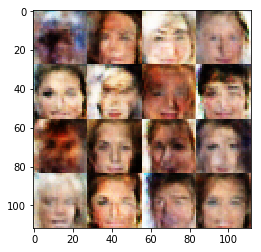

Epoch 1/1... Discriminator Loss: 0.1881... Generator Loss: 3.9862
Epoch 1/1... Discriminator Loss: 0.1887... Generator Loss: 3.8603
Epoch 1/1... Discriminator Loss: 0.1832... Generator Loss: 4.3031
Epoch 1/1... Discriminator Loss: 0.1832... Generator Loss: 4.4640
Epoch 1/1... Discriminator Loss: 0.1887... Generator Loss: 3.8585
Epoch 1/1... Discriminator Loss: 0.1887... Generator Loss: 3.8761
Epoch 1/1... Discriminator Loss: 0.1923... Generator Loss: 3.7263
Epoch 1/1... Discriminator Loss: 0.1924... Generator Loss: 3.7440
Epoch 1/1... Discriminator Loss: 0.1890... Generator Loss: 4.5995
Epoch 1/1... Discriminator Loss: 0.1843... Generator Loss: 4.5160


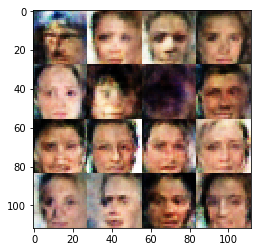

Epoch 1/1... Discriminator Loss: 0.1886... Generator Loss: 3.9476
Epoch 1/1... Discriminator Loss: 0.1832... Generator Loss: 4.4709
Epoch 1/1... Discriminator Loss: 0.1823... Generator Loss: 4.1923
Epoch 1/1... Discriminator Loss: 0.1835... Generator Loss: 4.6145
Epoch 1/1... Discriminator Loss: 0.1848... Generator Loss: 4.2355
Epoch 1/1... Discriminator Loss: 0.1839... Generator Loss: 4.2316
Epoch 1/1... Discriminator Loss: 0.2075... Generator Loss: 5.2762
Epoch 1/1... Discriminator Loss: 0.2031... Generator Loss: 5.4204
Epoch 1/1... Discriminator Loss: 0.1877... Generator Loss: 4.5073
Epoch 1/1... Discriminator Loss: 0.1875... Generator Loss: 3.9877


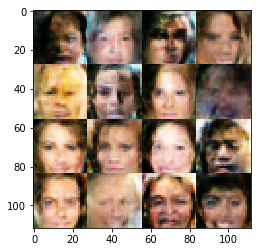

Epoch 1/1... Discriminator Loss: 0.1893... Generator Loss: 3.9285
Epoch 1/1... Discriminator Loss: 0.1867... Generator Loss: 4.9117
Epoch 1/1... Discriminator Loss: 0.1897... Generator Loss: 4.9460
Epoch 1/1... Discriminator Loss: 0.1907... Generator Loss: 3.8803
Epoch 1/1... Discriminator Loss: 0.1936... Generator Loss: 3.7669
Epoch 1/1... Discriminator Loss: 0.1894... Generator Loss: 4.0058
Epoch 1/1... Discriminator Loss: 0.1872... Generator Loss: 4.9628
Epoch 1/1... Discriminator Loss: 0.2048... Generator Loss: 3.4135
Epoch 1/1... Discriminator Loss: 0.1820... Generator Loss: 4.4808
Epoch 1/1... Discriminator Loss: 0.1836... Generator Loss: 4.3947


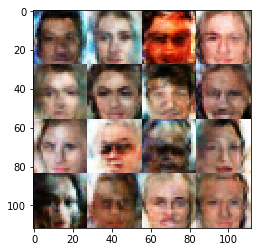

Epoch 1/1... Discriminator Loss: 0.1890... Generator Loss: 4.8027
Epoch 1/1... Discriminator Loss: 0.1847... Generator Loss: 4.0151
Epoch 1/1... Discriminator Loss: 0.1850... Generator Loss: 4.5025
Epoch 1/1... Discriminator Loss: 0.1828... Generator Loss: 4.3774
Epoch 1/1... Discriminator Loss: 0.1852... Generator Loss: 3.9744
Epoch 1/1... Discriminator Loss: 0.1870... Generator Loss: 3.9631
Epoch 1/1... Discriminator Loss: 0.1840... Generator Loss: 4.2485
Epoch 1/1... Discriminator Loss: 0.1851... Generator Loss: 4.5342
Epoch 1/1... Discriminator Loss: 0.1855... Generator Loss: 4.6317
Epoch 1/1... Discriminator Loss: 0.1834... Generator Loss: 4.3875


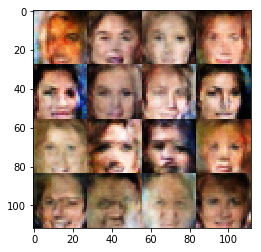

Epoch 1/1... Discriminator Loss: 0.1970... Generator Loss: 5.0961
Epoch 1/1... Discriminator Loss: 0.1851... Generator Loss: 4.2020
Epoch 1/1... Discriminator Loss: 0.2007... Generator Loss: 5.3900
Epoch 1/1... Discriminator Loss: 0.1846... Generator Loss: 4.1197
Epoch 1/1... Discriminator Loss: 0.1928... Generator Loss: 5.0795
Epoch 1/1... Discriminator Loss: 0.1868... Generator Loss: 4.6338
Epoch 1/1... Discriminator Loss: 0.1839... Generator Loss: 4.5055
Epoch 1/1... Discriminator Loss: 0.1832... Generator Loss: 4.0680
Epoch 1/1... Discriminator Loss: 0.1860... Generator Loss: 4.5369
Epoch 1/1... Discriminator Loss: 0.1875... Generator Loss: 3.9157


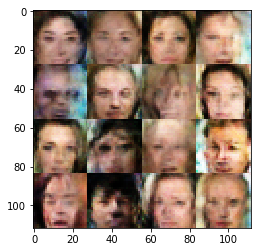

Epoch 1/1... Discriminator Loss: 0.1905... Generator Loss: 4.9081
Epoch 1/1... Discriminator Loss: 0.1824... Generator Loss: 4.3232
Epoch 1/1... Discriminator Loss: 0.1856... Generator Loss: 4.7077
Epoch 1/1... Discriminator Loss: 0.1838... Generator Loss: 4.4035
Epoch 1/1... Discriminator Loss: 0.1859... Generator Loss: 4.3882
Epoch 1/1... Discriminator Loss: 0.1859... Generator Loss: 4.1188
Epoch 1/1... Discriminator Loss: 0.1988... Generator Loss: 5.2774
Epoch 1/1... Discriminator Loss: 0.1844... Generator Loss: 4.2316
Epoch 1/1... Discriminator Loss: 0.1857... Generator Loss: 4.0215
Epoch 1/1... Discriminator Loss: 0.1881... Generator Loss: 3.9151


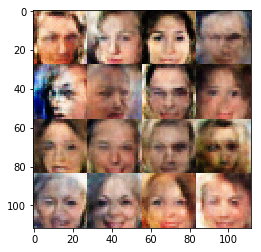

Epoch 1/1... Discriminator Loss: 0.2096... Generator Loss: 5.6443
Epoch 1/1... Discriminator Loss: 0.1862... Generator Loss: 3.9607
Epoch 1/1... Discriminator Loss: 0.1836... Generator Loss: 4.2906
Epoch 1/1... Discriminator Loss: 0.1857... Generator Loss: 3.9688
Epoch 1/1... Discriminator Loss: 0.1837... Generator Loss: 4.1001
Epoch 1/1... Discriminator Loss: 0.1892... Generator Loss: 3.9266
Epoch 1/1... Discriminator Loss: 0.1929... Generator Loss: 3.6569
Epoch 1/1... Discriminator Loss: 0.1864... Generator Loss: 4.1204
Epoch 1/1... Discriminator Loss: 0.1870... Generator Loss: 4.6803
Epoch 1/1... Discriminator Loss: 0.1879... Generator Loss: 4.1221


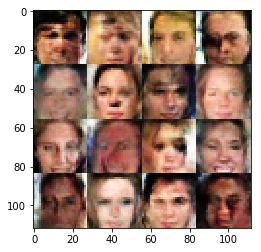

Epoch 1/1... Discriminator Loss: 0.1845... Generator Loss: 4.2653
Epoch 1/1... Discriminator Loss: 0.1818... Generator Loss: 4.2972
Epoch 1/1... Discriminator Loss: 0.1859... Generator Loss: 3.9379
Epoch 1/1... Discriminator Loss: 0.1898... Generator Loss: 4.1020
Epoch 1/1... Discriminator Loss: 0.1900... Generator Loss: 4.6467
Epoch 1/1... Discriminator Loss: 0.1797... Generator Loss: 4.5696
Epoch 1/1... Discriminator Loss: 0.1832... Generator Loss: 4.3546
Epoch 1/1... Discriminator Loss: 0.1846... Generator Loss: 4.2278
Epoch 1/1... Discriminator Loss: 0.1864... Generator Loss: 4.0945
Epoch 1/1... Discriminator Loss: 0.1916... Generator Loss: 5.1623


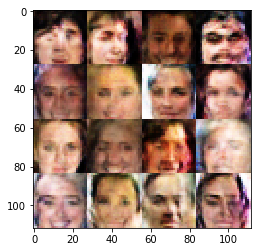

Epoch 1/1... Discriminator Loss: 0.1866... Generator Loss: 3.9995
Epoch 1/1... Discriminator Loss: 0.1893... Generator Loss: 3.8465
Epoch 1/1... Discriminator Loss: 0.2119... Generator Loss: 5.9317
Epoch 1/1... Discriminator Loss: 0.1820... Generator Loss: 4.3699
Epoch 1/1... Discriminator Loss: 0.1856... Generator Loss: 4.0050
Epoch 1/1... Discriminator Loss: 0.1836... Generator Loss: 4.5536
Epoch 1/1... Discriminator Loss: 0.1979... Generator Loss: 5.5989
Epoch 1/1... Discriminator Loss: 0.1937... Generator Loss: 3.8310
Epoch 1/1... Discriminator Loss: 0.1906... Generator Loss: 3.9316
Epoch 1/1... Discriminator Loss: 0.1867... Generator Loss: 3.9443


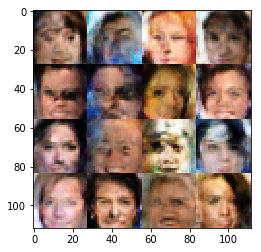

Epoch 1/1... Discriminator Loss: 0.1885... Generator Loss: 4.3250
Epoch 1/1... Discriminator Loss: 0.1891... Generator Loss: 5.0533
Epoch 1/1... Discriminator Loss: 0.1884... Generator Loss: 3.9322
Epoch 1/1... Discriminator Loss: 0.1817... Generator Loss: 4.5405
Epoch 1/1... Discriminator Loss: 0.1949... Generator Loss: 3.7459
Epoch 1/1... Discriminator Loss: 0.1856... Generator Loss: 3.9999
Epoch 1/1... Discriminator Loss: 0.1817... Generator Loss: 4.2058
Epoch 1/1... Discriminator Loss: 0.1928... Generator Loss: 3.6286
Epoch 1/1... Discriminator Loss: 0.1864... Generator Loss: 4.1754
Epoch 1/1... Discriminator Loss: 0.1854... Generator Loss: 4.8828


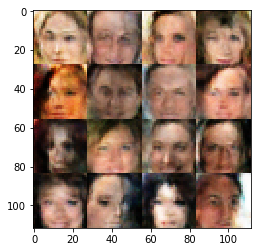

Epoch 1/1... Discriminator Loss: 0.1866... Generator Loss: 4.8967
Epoch 1/1... Discriminator Loss: 0.1909... Generator Loss: 4.8476
Epoch 1/1... Discriminator Loss: 0.1866... Generator Loss: 4.5145
Epoch 1/1... Discriminator Loss: 0.1842... Generator Loss: 4.1846
Epoch 1/1... Discriminator Loss: 0.1817... Generator Loss: 4.2162
Epoch 1/1... Discriminator Loss: 0.1831... Generator Loss: 4.1453
Epoch 1/1... Discriminator Loss: 0.1813... Generator Loss: 4.2762
Epoch 1/1... Discriminator Loss: 0.1851... Generator Loss: 4.5785
Epoch 1/1... Discriminator Loss: 0.1881... Generator Loss: 4.0547
Epoch 1/1... Discriminator Loss: 0.1868... Generator Loss: 4.0766


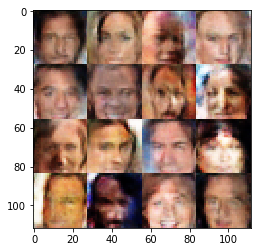

Epoch 1/1... Discriminator Loss: 0.1877... Generator Loss: 3.9183
Epoch 1/1... Discriminator Loss: 0.1824... Generator Loss: 4.5702
Epoch 1/1... Discriminator Loss: 0.1838... Generator Loss: 4.3532
Epoch 1/1... Discriminator Loss: 0.1864... Generator Loss: 4.6624
Epoch 1/1... Discriminator Loss: 0.1860... Generator Loss: 4.1719
Epoch 1/1... Discriminator Loss: 0.1848... Generator Loss: 4.6647
Epoch 1/1... Discriminator Loss: 0.1913... Generator Loss: 3.8763
Epoch 1/1... Discriminator Loss: 0.1929... Generator Loss: 4.9613
Epoch 1/1... Discriminator Loss: 0.1846... Generator Loss: 4.0453
Epoch 1/1... Discriminator Loss: 0.1841... Generator Loss: 4.0209


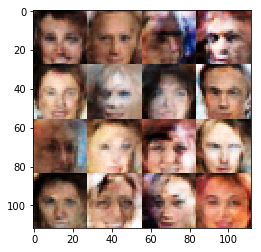

Epoch 1/1... Discriminator Loss: 0.1844... Generator Loss: 4.2666
Epoch 1/1... Discriminator Loss: 0.1861... Generator Loss: 4.0429
Epoch 1/1... Discriminator Loss: 0.1863... Generator Loss: 4.4082
Epoch 1/1... Discriminator Loss: 0.1816... Generator Loss: 4.3758
Epoch 1/1... Discriminator Loss: 0.1879... Generator Loss: 4.0001
Epoch 1/1... Discriminator Loss: 0.1833... Generator Loss: 4.7024
Epoch 1/1... Discriminator Loss: 0.1869... Generator Loss: 3.8938
Epoch 1/1... Discriminator Loss: 0.1821... Generator Loss: 4.2556
Epoch 1/1... Discriminator Loss: 0.1938... Generator Loss: 3.8204
Epoch 1/1... Discriminator Loss: 0.1888... Generator Loss: 3.7310


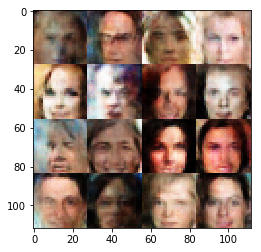

Epoch 1/1... Discriminator Loss: 0.1833... Generator Loss: 4.0829
Epoch 1/1... Discriminator Loss: 0.1793... Generator Loss: 4.5325
Epoch 1/1... Discriminator Loss: 0.1841... Generator Loss: 4.8694
Epoch 1/1... Discriminator Loss: 0.1863... Generator Loss: 4.0644
Epoch 1/1... Discriminator Loss: 0.1845... Generator Loss: 4.3988
Epoch 1/1... Discriminator Loss: 0.1927... Generator Loss: 3.8230
Epoch 1/1... Discriminator Loss: 0.1883... Generator Loss: 3.9363
Epoch 1/1... Discriminator Loss: 0.1849... Generator Loss: 4.1829
Epoch 1/1... Discriminator Loss: 0.1813... Generator Loss: 4.2175
Epoch 1/1... Discriminator Loss: 0.1843... Generator Loss: 4.5014


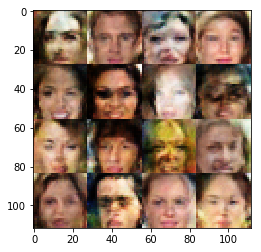

Epoch 1/1... Discriminator Loss: 0.1995... Generator Loss: 3.6922
Epoch 1/1... Discriminator Loss: 0.1856... Generator Loss: 4.0397
Epoch 1/1... Discriminator Loss: 0.1937... Generator Loss: 5.3280
Epoch 1/1... Discriminator Loss: 0.1872... Generator Loss: 3.9343
Epoch 1/1... Discriminator Loss: 0.1873... Generator Loss: 3.9913
Epoch 1/1... Discriminator Loss: 0.1840... Generator Loss: 4.5143
Epoch 1/1... Discriminator Loss: 0.1932... Generator Loss: 3.6135
Epoch 1/1... Discriminator Loss: 0.1807... Generator Loss: 4.2875
Epoch 1/1... Discriminator Loss: 0.1872... Generator Loss: 4.0643
Epoch 1/1... Discriminator Loss: 0.1874... Generator Loss: 3.9429


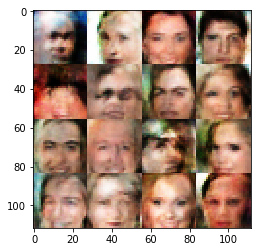

Epoch 1/1... Discriminator Loss: 0.2004... Generator Loss: 5.4884
Epoch 1/1... Discriminator Loss: 0.1847... Generator Loss: 4.1812
Epoch 1/1... Discriminator Loss: 0.1824... Generator Loss: 4.3068
Epoch 1/1... Discriminator Loss: 0.2209... Generator Loss: 5.8435
Epoch 1/1... Discriminator Loss: 0.1828... Generator Loss: 4.2011
Epoch 1/1... Discriminator Loss: 0.1888... Generator Loss: 3.9254
Epoch 1/1... Discriminator Loss: 0.1873... Generator Loss: 4.0016
Epoch 1/1... Discriminator Loss: 0.1898... Generator Loss: 3.9494
Epoch 1/1... Discriminator Loss: 0.1801... Generator Loss: 4.5631
Epoch 1/1... Discriminator Loss: 0.1890... Generator Loss: 4.0012


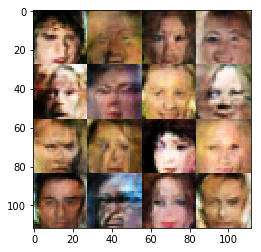

Epoch 1/1... Discriminator Loss: 0.1876... Generator Loss: 5.2504
Epoch 1/1... Discriminator Loss: 0.1906... Generator Loss: 3.9145
Epoch 1/1... Discriminator Loss: 0.1784... Generator Loss: 4.4404
Epoch 1/1... Discriminator Loss: 0.1850... Generator Loss: 4.0694
Epoch 1/1... Discriminator Loss: 0.1941... Generator Loss: 3.9946
Epoch 1/1... Discriminator Loss: 0.1808... Generator Loss: 4.6049
Epoch 1/1... Discriminator Loss: 0.1925... Generator Loss: 5.2883
Epoch 1/1... Discriminator Loss: 0.1837... Generator Loss: 4.1898
Epoch 1/1... Discriminator Loss: 0.1851... Generator Loss: 4.5751
Epoch 1/1... Discriminator Loss: 0.1925... Generator Loss: 4.9386


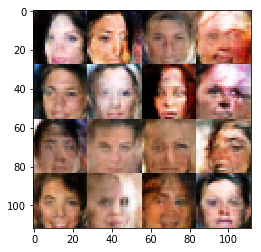

Epoch 1/1... Discriminator Loss: 0.1818... Generator Loss: 4.6212
Epoch 1/1... Discriminator Loss: 0.1849... Generator Loss: 4.6480
Epoch 1/1... Discriminator Loss: 0.1826... Generator Loss: 4.1250
Epoch 1/1... Discriminator Loss: 0.1966... Generator Loss: 3.8309
Epoch 1/1... Discriminator Loss: 0.1888... Generator Loss: 4.8287
Epoch 1/1... Discriminator Loss: 0.2178... Generator Loss: 3.2645
Epoch 1/1... Discriminator Loss: 0.1836... Generator Loss: 4.2945
Epoch 1/1... Discriminator Loss: 0.1811... Generator Loss: 4.6196
Epoch 1/1... Discriminator Loss: 0.1821... Generator Loss: 4.6955
Epoch 1/1... Discriminator Loss: 0.1851... Generator Loss: 4.0086


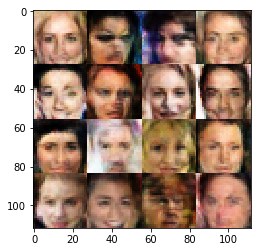

Epoch 1/1... Discriminator Loss: 0.1821... Generator Loss: 4.3663
Epoch 1/1... Discriminator Loss: 0.1909... Generator Loss: 5.1463
Epoch 1/1... Discriminator Loss: 0.1837... Generator Loss: 4.3708
Epoch 1/1... Discriminator Loss: 0.1775... Generator Loss: 4.5518
Epoch 1/1... Discriminator Loss: 0.1952... Generator Loss: 3.9015
Epoch 1/1... Discriminator Loss: 0.1815... Generator Loss: 4.4493
Epoch 1/1... Discriminator Loss: 0.1827... Generator Loss: 4.4091
Epoch 1/1... Discriminator Loss: 0.1848... Generator Loss: 4.9340
Epoch 1/1... Discriminator Loss: 0.1919... Generator Loss: 3.9415
Epoch 1/1... Discriminator Loss: 0.1823... Generator Loss: 4.1307


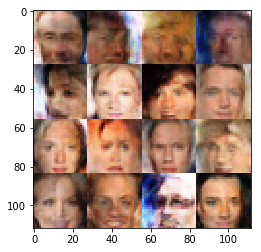

Epoch 1/1... Discriminator Loss: 0.1880... Generator Loss: 4.5322
Epoch 1/1... Discriminator Loss: 0.1896... Generator Loss: 4.0004
Epoch 1/1... Discriminator Loss: 0.1821... Generator Loss: 4.2704
Epoch 1/1... Discriminator Loss: 0.1776... Generator Loss: 4.4327
Epoch 1/1... Discriminator Loss: 0.1871... Generator Loss: 3.9006
Epoch 1/1... Discriminator Loss: 0.1878... Generator Loss: 3.9890
Epoch 1/1... Discriminator Loss: 0.1829... Generator Loss: 4.1377
Epoch 1/1... Discriminator Loss: 0.1900... Generator Loss: 5.2389
Epoch 1/1... Discriminator Loss: 0.1935... Generator Loss: 3.8247
Epoch 1/1... Discriminator Loss: 0.1863... Generator Loss: 4.1269


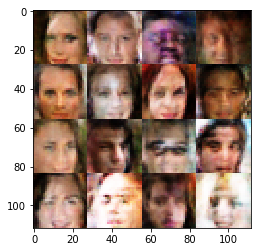

Epoch 1/1... Discriminator Loss: 0.1787... Generator Loss: 4.5096
Epoch 1/1... Discriminator Loss: 0.1874... Generator Loss: 4.0463
Epoch 1/1... Discriminator Loss: 0.1890... Generator Loss: 3.8302
Epoch 1/1... Discriminator Loss: 0.1834... Generator Loss: 4.5328
Epoch 1/1... Discriminator Loss: 0.1897... Generator Loss: 4.7586
Epoch 1/1... Discriminator Loss: 0.1796... Generator Loss: 4.5465
Epoch 1/1... Discriminator Loss: 0.1882... Generator Loss: 3.9265
Epoch 1/1... Discriminator Loss: 0.1848... Generator Loss: 4.9187
Epoch 1/1... Discriminator Loss: 0.1810... Generator Loss: 4.1672
Epoch 1/1... Discriminator Loss: 0.1832... Generator Loss: 4.8489


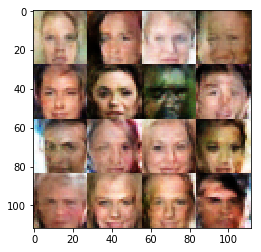

Epoch 1/1... Discriminator Loss: 0.1833... Generator Loss: 4.2985
Epoch 1/1... Discriminator Loss: 0.1879... Generator Loss: 4.0550
Epoch 1/1... Discriminator Loss: 0.1947... Generator Loss: 5.0448
Epoch 1/1... Discriminator Loss: 0.1822... Generator Loss: 4.3678
Epoch 1/1... Discriminator Loss: 0.1799... Generator Loss: 4.3724
Epoch 1/1... Discriminator Loss: 0.1857... Generator Loss: 4.2725
Epoch 1/1... Discriminator Loss: 0.1803... Generator Loss: 4.4411
Epoch 1/1... Discriminator Loss: 0.1800... Generator Loss: 4.7290
Epoch 1/1... Discriminator Loss: 0.1924... Generator Loss: 3.7907
Epoch 1/1... Discriminator Loss: 0.1837... Generator Loss: 4.1431


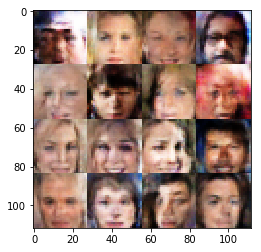

Epoch 1/1... Discriminator Loss: 0.1882... Generator Loss: 4.8933
Epoch 1/1... Discriminator Loss: 0.1839... Generator Loss: 4.2396
Epoch 1/1... Discriminator Loss: 0.1885... Generator Loss: 3.9984
Epoch 1/1... Discriminator Loss: 0.1821... Generator Loss: 4.2668
Epoch 1/1... Discriminator Loss: 0.1877... Generator Loss: 5.1704
Epoch 1/1... Discriminator Loss: 0.1855... Generator Loss: 4.0655
Epoch 1/1... Discriminator Loss: 0.1843... Generator Loss: 4.1105
Epoch 1/1... Discriminator Loss: 0.1795... Generator Loss: 4.4628
Epoch 1/1... Discriminator Loss: 0.1834... Generator Loss: 4.1686
Epoch 1/1... Discriminator Loss: 0.1794... Generator Loss: 4.5184


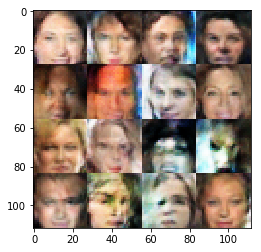

Epoch 1/1... Discriminator Loss: 0.1832... Generator Loss: 4.3387
Epoch 1/1... Discriminator Loss: 0.1882... Generator Loss: 4.0624
Epoch 1/1... Discriminator Loss: 0.1893... Generator Loss: 3.9084
Epoch 1/1... Discriminator Loss: 0.1793... Generator Loss: 4.4473
Epoch 1/1... Discriminator Loss: 0.1821... Generator Loss: 4.4456
Epoch 1/1... Discriminator Loss: 0.1830... Generator Loss: 4.2976
Epoch 1/1... Discriminator Loss: 0.1815... Generator Loss: 4.3052
Epoch 1/1... Discriminator Loss: 0.1850... Generator Loss: 4.2175
Epoch 1/1... Discriminator Loss: 0.1803... Generator Loss: 4.5083
Epoch 1/1... Discriminator Loss: 0.1877... Generator Loss: 4.9674


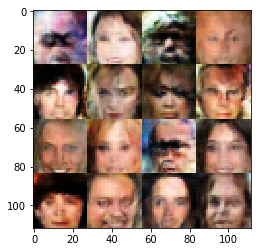

Epoch 1/1... Discriminator Loss: 0.1811... Generator Loss: 4.6523
Epoch 1/1... Discriminator Loss: 0.1808... Generator Loss: 4.3500
Epoch 1/1... Discriminator Loss: 0.1801... Generator Loss: 4.4342
Epoch 1/1... Discriminator Loss: 0.1810... Generator Loss: 4.5937
Epoch 1/1... Discriminator Loss: 0.2084... Generator Loss: 5.6332
Epoch 1/1... Discriminator Loss: 0.1872... Generator Loss: 4.0368
Epoch 1/1... Discriminator Loss: 0.1876... Generator Loss: 4.0084
Epoch 1/1... Discriminator Loss: 0.1809... Generator Loss: 4.2840
Epoch 1/1... Discriminator Loss: 0.1789... Generator Loss: 4.6648
Epoch 1/1... Discriminator Loss: 0.1773... Generator Loss: 4.7210


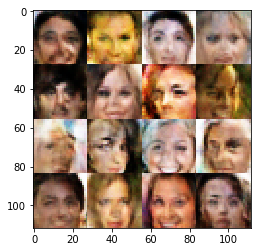

Epoch 1/1... Discriminator Loss: 0.1857... Generator Loss: 4.9133
Epoch 1/1... Discriminator Loss: 0.1802... Generator Loss: 4.7026
Epoch 1/1... Discriminator Loss: 0.1797... Generator Loss: 4.5793
Epoch 1/1... Discriminator Loss: 0.1815... Generator Loss: 4.3425
Epoch 1/1... Discriminator Loss: 0.1814... Generator Loss: 4.9062
Epoch 1/1... Discriminator Loss: 0.1888... Generator Loss: 4.0433
Epoch 1/1... Discriminator Loss: 0.1912... Generator Loss: 5.1863
Epoch 1/1... Discriminator Loss: 0.1864... Generator Loss: 5.1626
Epoch 1/1... Discriminator Loss: 0.1878... Generator Loss: 5.1779
Epoch 1/1... Discriminator Loss: 0.1853... Generator Loss: 4.3408


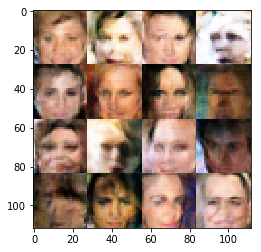

Epoch 1/1... Discriminator Loss: 0.1797... Generator Loss: 4.5154
Epoch 1/1... Discriminator Loss: 0.1880... Generator Loss: 4.8912
Epoch 1/1... Discriminator Loss: 0.1853... Generator Loss: 4.2423
Epoch 1/1... Discriminator Loss: 0.1868... Generator Loss: 5.0529
Epoch 1/1... Discriminator Loss: 0.1855... Generator Loss: 4.1849
Epoch 1/1... Discriminator Loss: 0.1809... Generator Loss: 4.3797
Epoch 1/1... Discriminator Loss: 0.1820... Generator Loss: 4.2633
Epoch 1/1... Discriminator Loss: 0.1831... Generator Loss: 4.1976
Epoch 1/1... Discriminator Loss: 0.1806... Generator Loss: 4.5127
Epoch 1/1... Discriminator Loss: 0.1881... Generator Loss: 5.1972


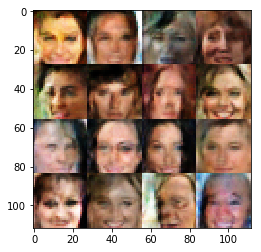

Epoch 1/1... Discriminator Loss: 0.1986... Generator Loss: 3.5947
Epoch 1/1... Discriminator Loss: 0.1784... Generator Loss: 4.2854
Epoch 1/1... Discriminator Loss: 0.1845... Generator Loss: 4.7625
Epoch 1/1... Discriminator Loss: 0.1849... Generator Loss: 4.5281
Epoch 1/1... Discriminator Loss: 0.1865... Generator Loss: 3.9942
Epoch 1/1... Discriminator Loss: 0.1864... Generator Loss: 4.1947
Epoch 1/1... Discriminator Loss: 0.1828... Generator Loss: 4.4897
Epoch 1/1... Discriminator Loss: 0.1867... Generator Loss: 4.2098
Epoch 1/1... Discriminator Loss: 0.1871... Generator Loss: 4.0527
Epoch 1/1... Discriminator Loss: 0.1851... Generator Loss: 4.9568


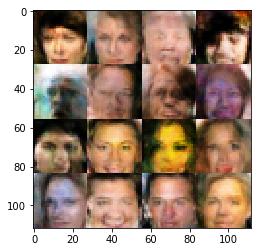

Epoch 1/1... Discriminator Loss: 0.1827... Generator Loss: 4.1997
Epoch 1/1... Discriminator Loss: 0.1801... Generator Loss: 4.5656
Epoch 1/1... Discriminator Loss: 0.1853... Generator Loss: 3.9307
Epoch 1/1... Discriminator Loss: 0.1794... Generator Loss: 4.5595
Epoch 1/1... Discriminator Loss: 0.1934... Generator Loss: 3.6963
Epoch 1/1... Discriminator Loss: 0.1822... Generator Loss: 4.2246
Epoch 1/1... Discriminator Loss: 0.1900... Generator Loss: 4.0266
Epoch 1/1... Discriminator Loss: 0.1847... Generator Loss: 3.9880
Epoch 1/1... Discriminator Loss: 0.1814... Generator Loss: 4.3861
Epoch 1/1... Discriminator Loss: 0.1876... Generator Loss: 4.1441


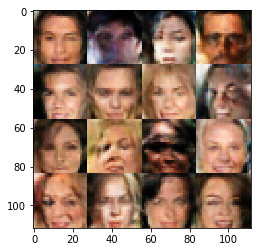

Epoch 1/1... Discriminator Loss: 0.1789... Generator Loss: 4.3521
Epoch 1/1... Discriminator Loss: 0.1928... Generator Loss: 3.9906
Epoch 1/1... Discriminator Loss: 0.1862... Generator Loss: 4.6873
Epoch 1/1... Discriminator Loss: 0.1900... Generator Loss: 4.9055
Epoch 1/1... Discriminator Loss: 0.1868... Generator Loss: 3.9184
Epoch 1/1... Discriminator Loss: 0.1828... Generator Loss: 4.8596
Epoch 1/1... Discriminator Loss: 0.1898... Generator Loss: 4.1228
Epoch 1/1... Discriminator Loss: 0.1830... Generator Loss: 5.0107
Epoch 1/1... Discriminator Loss: 0.1787... Generator Loss: 4.6698
Epoch 1/1... Discriminator Loss: 0.1842... Generator Loss: 4.6986


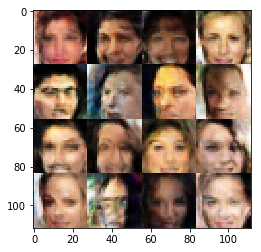

Epoch 1/1... Discriminator Loss: 0.1758... Generator Loss: 5.0028
Epoch 1/1... Discriminator Loss: 0.1873... Generator Loss: 3.8341
Epoch 1/1... Discriminator Loss: 0.1806... Generator Loss: 4.5175
Epoch 1/1... Discriminator Loss: 0.1843... Generator Loss: 4.0375
Epoch 1/1... Discriminator Loss: 0.1863... Generator Loss: 4.1211
Epoch 1/1... Discriminator Loss: 0.1839... Generator Loss: 5.2392
Epoch 1/1... Discriminator Loss: 0.1791... Generator Loss: 4.6427
Epoch 1/1... Discriminator Loss: 0.1837... Generator Loss: 4.0678
Epoch 1/1... Discriminator Loss: 0.1836... Generator Loss: 4.0748
Epoch 1/1... Discriminator Loss: 0.1873... Generator Loss: 4.9761


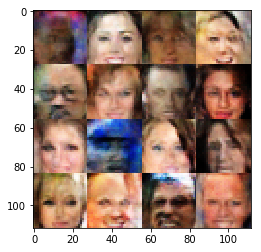

Epoch 1/1... Discriminator Loss: 0.1793... Generator Loss: 4.7799
Epoch 1/1... Discriminator Loss: 0.1811... Generator Loss: 4.7943
Epoch 1/1... Discriminator Loss: 0.1810... Generator Loss: 4.3423
Epoch 1/1... Discriminator Loss: 0.1902... Generator Loss: 4.0980
Epoch 1/1... Discriminator Loss: 0.1809... Generator Loss: 4.6593
Epoch 1/1... Discriminator Loss: 0.1808... Generator Loss: 4.2501
Epoch 1/1... Discriminator Loss: 0.1940... Generator Loss: 5.6388
Epoch 1/1... Discriminator Loss: 0.1941... Generator Loss: 3.9129
Epoch 1/1... Discriminator Loss: 0.1830... Generator Loss: 4.3432
Epoch 1/1... Discriminator Loss: 0.1797... Generator Loss: 4.6991


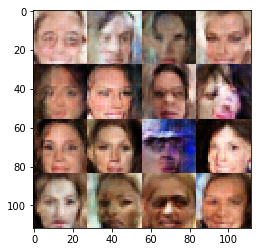

Epoch 1/1... Discriminator Loss: 0.1821... Generator Loss: 4.5561
Epoch 1/1... Discriminator Loss: 0.1825... Generator Loss: 4.2487
Epoch 1/1... Discriminator Loss: 0.1830... Generator Loss: 5.0753
Epoch 1/1... Discriminator Loss: 0.1787... Generator Loss: 4.5667
Epoch 1/1... Discriminator Loss: 0.1973... Generator Loss: 3.8370
Epoch 1/1... Discriminator Loss: 0.1817... Generator Loss: 4.2901
Epoch 1/1... Discriminator Loss: 0.1832... Generator Loss: 4.4326
Epoch 1/1... Discriminator Loss: 0.1768... Generator Loss: 4.5376
Epoch 1/1... Discriminator Loss: 0.1844... Generator Loss: 4.7902
Epoch 1/1... Discriminator Loss: 0.1847... Generator Loss: 4.3048


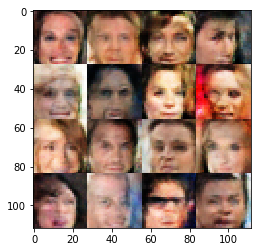

Epoch 1/1... Discriminator Loss: 0.1872... Generator Loss: 5.1142
Epoch 1/1... Discriminator Loss: 0.1908... Generator Loss: 3.9612
Epoch 1/1... Discriminator Loss: 0.1811... Generator Loss: 4.5050
Epoch 1/1... Discriminator Loss: 0.1798... Generator Loss: 4.6151
Epoch 1/1... Discriminator Loss: 0.1794... Generator Loss: 4.5514
Epoch 1/1... Discriminator Loss: 0.2060... Generator Loss: 5.9131
Epoch 1/1... Discriminator Loss: 0.1854... Generator Loss: 4.0837
Epoch 1/1... Discriminator Loss: 0.1795... Generator Loss: 4.2614
Epoch 1/1... Discriminator Loss: 0.1832... Generator Loss: 5.0756
Epoch 1/1... Discriminator Loss: 0.1783... Generator Loss: 4.6196


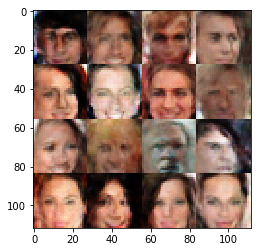

Epoch 1/1... Discriminator Loss: 0.1801... Generator Loss: 4.5743
Epoch 1/1... Discriminator Loss: 0.1792... Generator Loss: 4.6329
Epoch 1/1... Discriminator Loss: 0.1817... Generator Loss: 4.5495
Epoch 1/1... Discriminator Loss: 0.1824... Generator Loss: 4.6705
Epoch 1/1... Discriminator Loss: 0.1941... Generator Loss: 5.0483
Epoch 1/1... Discriminator Loss: 0.1843... Generator Loss: 4.2228
Epoch 1/1... Discriminator Loss: 0.1838... Generator Loss: 4.4445
Epoch 1/1... Discriminator Loss: 0.1773... Generator Loss: 4.8876
Epoch 1/1... Discriminator Loss: 0.1765... Generator Loss: 4.6166
Epoch 1/1... Discriminator Loss: 0.1847... Generator Loss: 4.0854


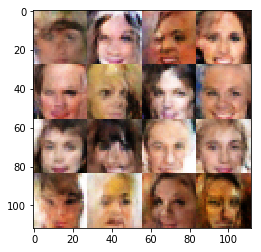

Epoch 1/1... Discriminator Loss: 0.1809... Generator Loss: 4.2787
Epoch 1/1... Discriminator Loss: 0.1887... Generator Loss: 4.3373
Epoch 1/1... Discriminator Loss: 0.1816... Generator Loss: 4.6762
Epoch 1/1... Discriminator Loss: 0.1841... Generator Loss: 4.1771
Epoch 1/1... Discriminator Loss: 0.1838... Generator Loss: 4.8942
Epoch 1/1... Discriminator Loss: 0.1815... Generator Loss: 4.5079
Epoch 1/1... Discriminator Loss: 0.1846... Generator Loss: 5.0912
Epoch 1/1... Discriminator Loss: 0.1939... Generator Loss: 5.3375
Epoch 1/1... Discriminator Loss: 0.1846... Generator Loss: 5.0491
Epoch 1/1... Discriminator Loss: 0.2029... Generator Loss: 5.5403


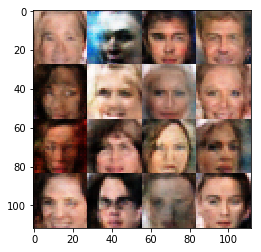

Epoch 1/1... Discriminator Loss: 0.1867... Generator Loss: 5.0084
Epoch 1/1... Discriminator Loss: 0.1804... Generator Loss: 4.4127
Epoch 1/1... Discriminator Loss: 0.1809... Generator Loss: 4.2712
Epoch 1/1... Discriminator Loss: 0.1823... Generator Loss: 4.3923
Epoch 1/1... Discriminator Loss: 0.1840... Generator Loss: 4.2523
Epoch 1/1... Discriminator Loss: 0.1831... Generator Loss: 4.9145
Epoch 1/1... Discriminator Loss: 0.1816... Generator Loss: 4.8430
Epoch 1/1... Discriminator Loss: 0.1936... Generator Loss: 5.4250
Epoch 1/1... Discriminator Loss: 0.2034... Generator Loss: 5.6098
Epoch 1/1... Discriminator Loss: 0.1842... Generator Loss: 4.7196


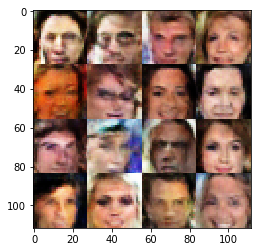

Epoch 1/1... Discriminator Loss: 0.1779... Generator Loss: 4.4787
Epoch 1/1... Discriminator Loss: 0.1814... Generator Loss: 4.3583
Epoch 1/1... Discriminator Loss: 0.1791... Generator Loss: 4.5925
Epoch 1/1... Discriminator Loss: 0.1812... Generator Loss: 4.2446
Epoch 1/1... Discriminator Loss: 0.1805... Generator Loss: 4.7342
Epoch 1/1... Discriminator Loss: 0.1821... Generator Loss: 4.9189
Epoch 1/1... Discriminator Loss: 0.1839... Generator Loss: 4.4468
Epoch 1/1... Discriminator Loss: 0.1915... Generator Loss: 5.1176
Epoch 1/1... Discriminator Loss: 0.1789... Generator Loss: 4.5130
Epoch 1/1... Discriminator Loss: 0.1793... Generator Loss: 4.3492


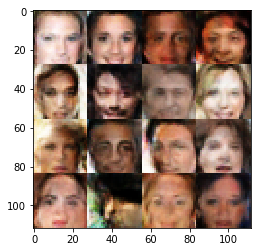

Epoch 1/1... Discriminator Loss: 0.1775... Generator Loss: 4.6120
Epoch 1/1... Discriminator Loss: 0.1822... Generator Loss: 4.9783
Epoch 1/1... Discriminator Loss: 0.1824... Generator Loss: 4.7364
Epoch 1/1... Discriminator Loss: 0.1799... Generator Loss: 4.6472
Epoch 1/1... Discriminator Loss: 0.1809... Generator Loss: 4.6517
Epoch 1/1... Discriminator Loss: 0.1793... Generator Loss: 4.4175
Epoch 1/1... Discriminator Loss: 0.2000... Generator Loss: 6.0389
Epoch 1/1... Discriminator Loss: 0.1820... Generator Loss: 4.1523
Epoch 1/1... Discriminator Loss: 0.1787... Generator Loss: 4.7560
Epoch 1/1... Discriminator Loss: 0.1860... Generator Loss: 4.2605


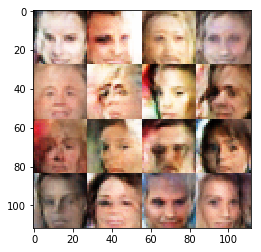

Epoch 1/1... Discriminator Loss: 0.1890... Generator Loss: 5.0191
Epoch 1/1... Discriminator Loss: 0.1875... Generator Loss: 5.1999
Epoch 1/1... Discriminator Loss: 0.1885... Generator Loss: 4.2262
Epoch 1/1... Discriminator Loss: 0.1903... Generator Loss: 4.0411
Epoch 1/1... Discriminator Loss: 0.1864... Generator Loss: 4.0411
Epoch 1/1... Discriminator Loss: 0.1808... Generator Loss: 5.0918
Epoch 1/1... Discriminator Loss: 0.1792... Generator Loss: 4.8694
Epoch 1/1... Discriminator Loss: 0.1911... Generator Loss: 5.2525
Epoch 1/1... Discriminator Loss: 0.1792... Generator Loss: 4.4627
Epoch 1/1... Discriminator Loss: 0.1841... Generator Loss: 4.2060


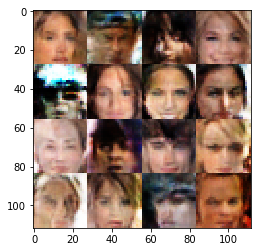

Epoch 1/1... Discriminator Loss: 0.1809... Generator Loss: 4.8902
Epoch 1/1... Discriminator Loss: 0.1907... Generator Loss: 5.4481
Epoch 1/1... Discriminator Loss: 0.1855... Generator Loss: 4.2327
Epoch 1/1... Discriminator Loss: 0.1859... Generator Loss: 4.1719
Epoch 1/1... Discriminator Loss: 0.1869... Generator Loss: 4.1393
Epoch 1/1... Discriminator Loss: 0.1829... Generator Loss: 4.8310
Epoch 1/1... Discriminator Loss: 0.1839... Generator Loss: 4.7858
Epoch 1/1... Discriminator Loss: 0.1786... Generator Loss: 4.5619
Epoch 1/1... Discriminator Loss: 0.1794... Generator Loss: 4.5000
Epoch 1/1... Discriminator Loss: 0.1925... Generator Loss: 3.9538


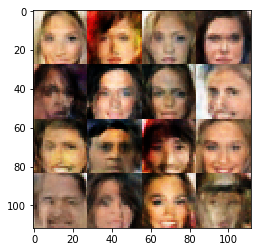

Epoch 1/1... Discriminator Loss: 0.1798... Generator Loss: 4.4500
Epoch 1/1... Discriminator Loss: 0.1868... Generator Loss: 4.0586
Epoch 1/1... Discriminator Loss: 0.1856... Generator Loss: 4.1645
Epoch 1/1... Discriminator Loss: 0.1852... Generator Loss: 4.1922


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0006
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.